# Trade Correlation

In this notebook we explore clustering of countries based on their trade correlation. We use the data from the [World Bank](https://wits.worldbank.org/) to calculate the correlation between the trade of different countries. We then use this correlation to cluster the countries. 

In [ ]:
! pip install -q geopandas, pycountry

In [3]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import graph_tool.all as gt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import os
import geopandas as gpd
from matplotlib.colors import rgb2hex
import matplotlib.colors as mcolors
import requests
import zipfile
import io
from pathlib import Path

## Preprocessing Dataset

We have already created the dataset by web scraping the data from the World Bank. The dataset contains the trade data for 2022. We will load the dataset and preprocess it.

The edge weights in the normalized weighted adjacency matrix are created based on trade intensity between countries. Here's a step-by-step explanation of the process:

1. **Data Cleaning and Aggregation**:
    - The input CSV file is read into a DataFrame.
    - Rows where either 'Country' or 'Reference Country' is in the list of excluded regions are removed.
    - Unique countries are identified from the 'Reference Country' and 'Country' columns.
    - Export values are cleaned and aggregated to calculate total exports for each country and bilateral exports between country pairs.

2. **Matrix Initialization**:
    - An empty matrix of zeros is initialized with dimensions equal to the number of unique countries.
    - A dictionary is created for quick lookup of country indices.

3. **Trade Intensity Calculation**:
    - For each pair of countries (excluding self-loops), the following steps are performed:
        - Retrieve the export values from country A to country B and from country B to country A.
        - Calculate the total bilateral trade as the sum of these export values.
        - Calculate the total exports for each country.
        - Compute the trade intensity as the ratio of total bilateral trade to the sum of total exports of both countries.
        - Apply a weight threshold to set trade intensities below the threshold to zero.

The edge weights in the normalized weighted adjacency matrix are calculated based on the trade intensity between two countries. The formula used is:

$$ Trade\ Intensity_{A,B} = \frac{Total\ Bilateral\ Trade_{A,B}}{Total\ Exports_A + Total\ Exports_B} $$

Where:
- $Total\ Bilateral\ Trade_{A,B}$ is the sum of exports from country A to country B and from country B to country A.
- $Total\ Exports_A$ is the total exports from country A to all other countries.
- $Total\ Exports_B$ is the total exports from country B to all other countries.

If the calculated trade intensity is below a specified weight threshold, it is set to zero:

$$ Trade\ Intensity_{A,B} = 0 \quad if \quad Trade\ Intensity_{A,B} < Weight\ Threshold $$

4. **Matrix Population**:
    - The calculated trade intensity is assigned to the corresponding cell in the matrix.

5. **Output**:
    - The resulting matrix is converted to a DataFrame with countries as both rows and columns.
    - The DataFrame is saved to a CSV file.

Certainly! Here is the content formatted for a Jupyter Notebook Markdown cell:



In [48]:
import pandas as pd
import numpy as np

def process_trade_data_normalized(file_path, weight_threshold):
    """
    Processes trade data to create a normalized weighted adjacency matrix based on trade intensity,
    excluding specified regions.

    Parameters:
    - file_path (str): Path to the input CSV file containing trade data.
    - weight_threshold (float): Minimum weight to consider; weights below this are set to zero.

    Returns:
    - pd.DataFrame: A DataFrame representing the normalized weighted adjacency matrix.
    """
    # Define regions to exclude
    regions = [
        "World",
        "Europe & Central Asia",
        "East Asia & Pacific",
        "North America",
        "Middle East & North Africa",
        "Sub-Saharan Africa",
        "South Asia",
        " World",
        "Latin America & Caribbean"
    ]
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Remove rows where either 'Country' or 'Reference Country' is in the regions list
    df = df[
        (~df['Country'].isin(regions)) & 
        (~df['Reference Country'].isin(regions))
    ]
    
    # Get unique countries (combining Reference Country and Country columns)
    all_countries = sorted(set(df['Reference Country']).union(set(df['Country'])))
    
    # Initialize dictionaries to store exports
    exports = {country: 0.0 for country in all_countries}
    bilateral_exports = {}
    
    # Clean and aggregate export values
    for _, row in df.iterrows():
        ref_country = row["Reference Country"]
        country = row["Country"]
        
        # Clean and convert the export value
        export_str = str(row["Export (US$ Thousand)"]).replace(',', '').replace('*', '').strip()
        try:
            export = float(export_str) if export_str else 0.0
        except ValueError:
            # Handle cases where conversion fails
            export = 0.0
        
        exports[ref_country] += export
        bilateral_exports[(ref_country, country)] = bilateral_exports.get((ref_country, country), 0.0) + export
    
    # Initialize an empty matrix filled with zeros
    n = len(all_countries)
    matrix = np.zeros((n, n))
    
    # Create a dictionary for quick country to index lookup
    country_to_index = {country: i for i, country in enumerate(all_countries)}
    
    # Iterate over all unique country pairs to calculate normalized weights
    for i, country_a in enumerate(all_countries):
        for j, country_b in enumerate(all_countries):
            if country_a == country_b:
                continue  # No self-loops; weight remains zero
            
            # Get exports from A to B and B to A
            export_a_to_b = bilateral_exports.get((country_a, country_b), 0.0)
            export_b_to_a = bilateral_exports.get((country_b, country_a), 0.0)
            
            # Calculate total bilateral trade
            total_trade = export_a_to_b + export_b_to_a
            
            # Calculate total exports for normalization
            total_exports_a = exports[country_a]
            total_exports_b = exports[country_b]
            
            if total_exports_a > 0 and total_exports_b > 0:
                # Calculate trade intensity
                trade_intensity = total_trade / (total_exports_a + total_exports_b)
            else:
                trade_intensity = 0.0  # Handle division by zero if any country has zero exports
            
            # Apply weight threshold
            if trade_intensity < weight_threshold:
                trade_intensity = 0.0
            
            # Assign the normalized weight
            matrix[i][j] = trade_intensity
    
    # Create the output DataFrame
    matrix_df = pd.DataFrame(matrix, index=all_countries, columns=all_countries)
    
    # Optionally, reset index and column names if needed
    matrix_df.reset_index(inplace=True)
    matrix_df.rename(columns={'index': 'Country'}, inplace=True)
    
    return matrix_df

def save_matrix(matrix_df, output_file):
    """
    Saves the adjacency matrix to a CSV file.

    Parameters:
    - matrix_df (pd.DataFrame): The adjacency matrix DataFrame.
    - output_file (str): Path to the output CSV file.
    """
    matrix_df.to_csv(output_file, index=False)

# Example usage
if __name__ == "__main__":
    input_file = "./trade/trade_data.csv"            # Your input file path
    output_file = "./trade/trade_matrix_normalized.csv"  # Your output file path

    # Process the trade data with normalized weights
    matrix_df = process_trade_data_normalized(input_file, weight_threshold=0)

    # Save the resulting matrix to a CSV file
    save_matrix(matrix_df, output_file)


### Analysing trade data

In [53]:
# Add this diagnostic code after loading the CSV
def analyze_trade_data(df):
    # Count countries with zero exports
    zero_export_countries = set()
    no_trade_pairs = set()
    
    for _, row in df.iterrows():
        ref_country = row["Reference Country"]
        country = row["Country"]
        export_str = str(row["Export (US$ Thousand)"]).replace(',', '').replace('*', '').strip()
        
        try:
            export = float(export_str) if export_str else 0.0
            if export == 0:
                zero_export_countries.add(ref_country)
                no_trade_pairs.add((ref_country, country))
        except ValueError:
            zero_export_countries.add(ref_country)
    
    print(f"\nDiagnostics:")
    print(f"Total unique countries: {len(set(df['Reference Country']).union(set(df['Country'])))}")
    print(f"Countries with zero exports: {len(zero_export_countries)}")
    print(f"Country pairs with no trade: {len(no_trade_pairs)}")
    
# Use it before matrix creation
df = pd.read_csv("./trade/trade_data.csv")
analyze_trade_data(df)


Diagnostics:
Total unique countries: 255
Countries with zero exports: 146
Country pairs with no trade: 5665


In [ ]:
def analyze_trade_imbalances(df):
    """Analyze trade imbalances and excluded countries"""
    # Get all unique countries
    all_countries = set(df['Reference Country'].unique()).union(set(df['Country'].unique()))
    
    # Create dictionary to store bilateral trade
    trade_flows = {}
    imbalances = {}
    
    for _, row in df.iterrows():
        exp_country = row['Reference Country']
        imp_country = row['Country']
        export_val = float(str(row["Export (US$ Thousand)"]).replace(',', '').replace('*', '').strip() or 0)
        
        # Store export flow
        trade_flows[(exp_country, imp_country)] = export_val
        
        # Calculate imbalance if we have both directions
        if (imp_country, exp_country) in trade_flows:
            forward = trade_flows[(exp_country, imp_country)]
            reverse = trade_flows[(imp_country, exp_country)]
            imbalance = abs(forward - reverse) / (forward + reverse) if (forward + reverse) > 0 else 0
            imbalances[(exp_country, imp_country)] = imbalance
    
    # Find excluded countries (those with no significant trade)
    active_countries = set()
    for (exp, imp), val in trade_flows.items():
        if val > 0:
            active_countries.add(exp)
            active_countries.add(imp)
    
    excluded = all_countries - active_countries
    
    return excluded, imbalances, trade_flows

def calculate_normalized_weights(df, min_threshold=1e-6):
    """
    Calculate normalized weights considering:
    1. Trade imbalances
    2. Size differences
    3. Relative importance
    """
    # Get trade data
    excluded, imbalances, trade_flows = analyze_trade_imbalances(df)
    
    # Calculate total trade volume for each country
    country_volumes = {}
    for (exp, imp), val in trade_flows.items():
        country_volumes[exp] = country_volumes.get(exp, 0) + val
        country_volumes[imp] = country_volumes.get(imp, 0) + val
    
    # Get median trade volume for normalization
    median_volume = np.median(list(country_volumes.values()))
    
    # Calculate normalized weights
    normalized_weights = {}
    for (exp, imp), val in trade_flows.items():
        if val > 0:
            # Components for weight calculation:
            
            # 1. Base trade intensity
            intensity = val / np.sqrt(country_volumes[exp] * country_volumes[imp])
            
            # 2. Size normalization (relative to median)
            size_factor = np.sqrt(median_volume / max(country_volumes[exp], country_volumes[imp]))
            
            # 3. Imbalance penalty
            imbalance_factor = 1 - 0.5 * imbalances.get((exp, imp), 0)
            
            # Combine factors
            weight = intensity * size_factor * imbalance_factor
            
            # Apply threshold
            if weight >= min_threshold:
                normalized_weights[(exp, imp)] = weight
    
    return normalized_weights, excluded

# Use the functions
def analyze_trade_network(file_path):
    df = pd.read_csv(file_path)
    weights, excluded = calculate_normalized_weights(df)
    
    print("\nExcluded Countries:")
    print("-" * 20)
    for country in sorted(excluded):
        print(country)
        
    print(f"\nTotal active connections: {len(weights)}")
    print(f"Excluded countries: {len(excluded)}")
    
    return weights, excluded

weights, excluded = analyze_trade_network("./trade/trade_data.csv")


Excluded Countries:
--------------------
Br. Antr. Terr

Total active connections: 18344
Excluded countries: 1


In [65]:
def analyze_trade_network(matrix_df, min_weight=0):
    """
    Analyze trade network properties
    """
    # Create NetworkX graph
    G = nx.from_pandas_adjacency(matrix_df.set_index('Country'))
    
    # Basic network metrics
    print("\nNetwork Statistics:")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    print(f"Density: {nx.density(G):.4f}")
    
    # Calculate centrality measures
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    eigenvector_cent = nx.eigenvector_centrality_numpy(G)
    
    # Store metrics in DataFrame
    metrics_df = pd.DataFrame({
        'Degree': degree_cent,
        'Betweenness': betweenness_cent,
        'Eigenvector': eigenvector_cent
    })
    
    # Find strongest connections
    edges = [(u, v, d['weight']) for (u, v, d) in G.edges(data=True)]
    strongest_edges = sorted(edges, key=lambda x: x[2], reverse=True)[:10]
    
    print("\nTop 10 Strongest Trade Relationships:")
    for u, v, w in strongest_edges:
        print(f"{u} <-> {v}: {w:.4f}")
    
    return G, metrics_df

# Run analysis
G, metrics = analyze_trade_network(matrix_df)


# Save metrics
metrics.to_csv('./trade/network_metrics.csv')


Network Statistics:
Nodes: 246
Edges: 8179
Density: 0.2714

Top 10 Strongest Trade Relationships:
Canada <-> United States: 0.3060
Mexico <-> United States: 0.2942
Guyana <-> Panama: 0.2232
Latvia <-> Lithuania: 0.1466
El Salvador <-> Guatemala: 0.1424
Belgium <-> Netherlands: 0.1305
China <-> United States: 0.1302
Ecuador <-> Panama: 0.1281
Germany <-> Netherlands: 0.1251
Estonia <-> Latvia: 0.1226


In [56]:
# Update weight_threshold based on distribution
weights = [d['weight'] for (u,v,d) in G.edges(data=True)]
q25, q75 = np.percentile(weights, [25, 75])
weight_threshold = q25  # or adjust based on analysis needs

# Create filtered graph for community detection
G_filtered = G.copy()
edges_to_remove = [(u,v) for (u,v,d) in G_filtered.edges(data=True) 
                   if d['weight'] < weight_threshold]
G_filtered.remove_edges_from(edges_to_remove)

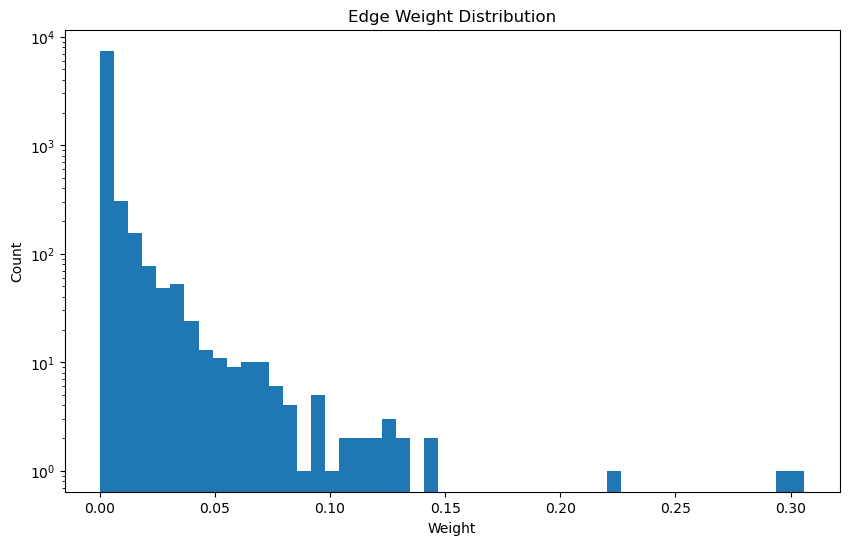

In [58]:
def plot_weight_distribution(G):
    weights = [d['weight'] for (u,v,d) in G.edges(data=True)]
    
    plt.figure(figsize=(10,6))
    plt.hist(weights, bins=50)
    plt.title('Edge Weight Distribution')
    plt.xlabel('Weight')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.savefig('./trade/weight_distribution.png')
    plt.show()

plot_weight_distribution(G)

In [66]:
def analyze_trade_weights(G):
    """Analyze trade network weight distribution"""
    # Get weights
    G = nx.from_pandas_adjacency(matrix_df.set_index('Country'))
    weights = [d['weight'] for (u,v,d) in G.edges(data=True)]
    weights = np.array(weights)
    
    # Calculate distribution statistics
    stats = {
        'mean': np.mean(weights),
        'median': np.median(weights),
        'std': np.std(weights),
        'percentiles': np.percentile(weights, [25, 50, 75, 90, 95, 99])
    }
    
    # Suggest thresholds based on distribution
    suggested_thresholds = {
        'conservative': stats['percentiles'][0],  # 25th percentile
        'moderate': stats['percentiles'][2],      # 75th percentile
        'aggressive': stats['percentiles'][4]      # 95th percentile
    }
    
    print("\nWeight Distribution Statistics:")
    print(f"Mean: {stats['mean']:.6f}")
    print(f"Median: {stats['median']:.6f}")
    print(f"Std Dev: {stats['std']:.6f}")
    print("\nPercentiles:")
    print(f"25th: {stats['percentiles'][0]:.6f}")
    print(f"75th: {stats['percentiles'][2]:.6f}")
    print(f"95th: {stats['percentiles'][4]:.6f}")
    
    print("\nSuggested Thresholds:")
    for name, threshold in suggested_thresholds.items():
        edges_kept = sum(1 for w in weights if w >= threshold)
        print(f"{name}: {threshold:.6f} (keeps {edges_kept} edges)")
    
    return stats, suggested_thresholds

# Run analysis
stats, thresholds = analyze_trade_weights(G)


Weight Distribution Statistics:
Mean: 0.002722
Median: 0.000170
Std Dev: 0.010569

Percentiles:
25th: 0.000018
75th: 0.001159
95th: 0.012986

Suggested Thresholds:
conservative: 0.000018 (keeps 6134 edges)
moderate: 0.001159 (keeps 2045 edges)
aggressive: 0.012986 (keeps 409 edges)


In [67]:
def analyze_network_at_thresholds(G, thresholds):
    """Analyze network properties at different thresholds"""
    results = {}
    
    for name, threshold in thresholds.items():
        # Create filtered graph
        G_filtered = G.copy()
        edges_to_remove = [(u,v) for (u,v,d) in G_filtered.edges(data=True) 
                          if d['weight'] < threshold]
        G_filtered.remove_edges_from(edges_to_remove)
        
        # Calculate metrics
        metrics = {
            'nodes': G_filtered.number_of_nodes(),
            'edges': G_filtered.number_of_edges(),
            'density': nx.density(G_filtered),
            'components': len(list(nx.connected_components(G_filtered))),
            'avg_clustering': nx.average_clustering(G_filtered),
            'avg_path_length': nx.average_shortest_path_length(G_filtered) 
                             if nx.is_connected(G_filtered) else float('inf')
        }
        
        results[name] = metrics
        
        print(f"\nNetwork at {name} threshold ({threshold:.6f}):")
        print(f"Nodes: {metrics['nodes']}")
        print(f"Edges: {metrics['edges']}")
        print(f"Density: {metrics['density']:.4f}")
        print(f"Components: {metrics['components']}")
        print(f"Avg Clustering: {metrics['avg_clustering']:.4f}")
        if metrics['avg_path_length'] != float('inf'):
            print(f"Avg Path Length: {metrics['avg_path_length']:.4f}")
        else:
            print("Avg Path Length: N/A (Disconnected)")
    
    return results

# Run analysis with the thresholds we found
thresholds = {
    'conservative': 0.000018,
    'moderate': 0.001159,
    'aggressive': 0.012986
}
G = nx.from_pandas_adjacency(matrix_df.set_index('Country'))
network_stats = analyze_network_at_thresholds(G, thresholds)


Network at conservative threshold (0.000018):
Nodes: 246
Edges: 6141
Density: 0.2038
Components: 103
Avg Clustering: 0.4809
Avg Path Length: N/A (Disconnected)

Network at moderate threshold (0.001159):
Nodes: 246
Edges: 2045
Density: 0.0679
Components: 106
Avg Clustering: 0.3482
Avg Path Length: N/A (Disconnected)

Network at aggressive threshold (0.012986):
Nodes: 246
Edges: 409
Density: 0.0136
Components: 120
Avg Clustering: 0.2369
Avg Path Length: N/A (Disconnected)


In [68]:
def analyze_components(G, thresholds):
    """Analyze components at each threshold"""
    for name, threshold in thresholds.items():
        # Create filtered graph
        G_filtered = G.copy()
        edges_to_remove = [(u,v) for (u,v,d) in G_filtered.edges(data=True) 
                          if d['weight'] < threshold]
        G_filtered.remove_edges_from(edges_to_remove)
        
        # Get components
        components = list(nx.connected_components(G_filtered))
        components.sort(key=len, reverse=True)
        
        print(f"\nComponent Analysis for {name} threshold ({threshold:.6f}):")
        print(f"Total components: {len(components)}")
        print("\nLargest components:")
        for i, comp in enumerate(components[:5]):
            print(f"Component {i+1}: {len(comp)} nodes")
            if i == 0:  # For largest component
                subgraph = G_filtered.subgraph(comp)
                print(f"Density: {nx.density(subgraph):.4f}")
                print(f"Avg Clustering: {nx.average_clustering(subgraph):.4f}")
                print("Sample members:", list(comp)[:5])
        
        # Analyze isolated nodes
        isolated = [n for n in G_filtered.nodes() if G_filtered.degree(n) == 0]
        print(f"\nIsolated nodes: {len(isolated)}")
        if isolated:
            print("Sample isolated:", isolated[:5])

# Run component analysis
analyze_components(G, thresholds)


Component Analysis for conservative threshold (0.000018):
Total components: 103

Largest components:
Component 1: 144 nodes
Density: 0.5964
Avg Clustering: 0.8215
Sample members: ['Ethiopia(excludes Eritrea)', 'Niger', 'Central African Republic', 'Chile', 'Hungary']
Component 2: 1 nodes
Component 3: 1 nodes
Component 4: 1 nodes
Component 5: 1 nodes

Isolated nodes: 102
Sample isolated: ['Afghanistan', 'Algeria', 'American Samoa', 'Anguila', 'Antarctica']

Component Analysis for moderate threshold (0.001159):
Total components: 106

Largest components:
Component 1: 141 nodes
Density: 0.2072
Avg Clustering: 0.6075
Sample members: ['Ethiopia(excludes Eritrea)', 'Niger', 'Chile', 'Hungary', 'Fiji']
Component 2: 1 nodes
Component 3: 1 nodes
Component 4: 1 nodes
Component 5: 1 nodes

Isolated nodes: 105
Sample isolated: ['Afghanistan', 'Algeria', 'American Samoa', 'Anguila', 'Antarctica']

Component Analysis for aggressive threshold (0.012986):
Total components: 120

Largest components:
Comp

In [79]:
def analyze_main_component(G, threshold=0.001159):
    """Analyze and detect communities in main component"""
    # Filter graph with threshold
    G_filtered = G.copy()
    edges_to_remove = [(u,v) for (u,v,d) in G_filtered.edges(data=True) 
                      if d['weight'] < threshold]
    G_filtered.remove_edges_from(edges_to_remove)
    
    # Get largest component
    components = list(nx.connected_components(G_filtered))
    main_component = max(components, key=len)
    main_graph = G_filtered.subgraph(main_component)
    
    # Calculate metrics for main component
    print("\nMain Component Analysis:")
    print(f"Nodes: {main_graph.number_of_nodes()}")
    print(f"Edges: {main_graph.number_of_edges()}")
    print(f"Density: {nx.density(main_graph):.4f}")
    print(f"Avg Clustering: {nx.average_clustering(main_graph):.4f}")
    
    # Detect communities using Louvain
    communities = nx.community.louvain_communities(main_graph, weight='weight')
    
    print(f"\nCommunity Detection Results:")
    print(f"Number of communities: {len(communities)}")
    
    # Analyze each community
    for i, comm in enumerate(communities):
        subgraph = main_graph.subgraph(comm)
        print(f"\nCommunity {i+1}:")
        print(f"Size: {len(comm)} nodes")
        print(f"Density: {nx.density(subgraph):.4f}")
        print(f"Internal edges: {subgraph.number_of_edges()}")
        print("Sample members:", list(comm)[:5])
        
    return main_graph, communities

# Run analysis on main component
main_graph, communities = analyze_main_component(G)


Main Component Analysis:
Nodes: 141
Edges: 2045
Density: 0.2072
Avg Clustering: 0.6075

Community Detection Results:
Number of communities: 7

Community 1:
Size: 21 nodes
Density: 0.6857
Internal edges: 144
Sample members: ['Spain', 'Austria', 'Hungary', 'Germany', 'Morocco']

Community 2:
Size: 16 nodes
Density: 0.4833
Internal edges: 58
Sample members: ['Ethiopia(excludes Eritrea)', 'Tanzania', 'Malawi', 'South Africa', 'Mozambique']

Community 3:
Size: 25 nodes
Density: 0.4200
Internal edges: 126
Sample members: ['Suriname', 'Argentina', 'Brazil', 'Dominican Republic', 'Bolivia']

Community 4:
Size: 25 nodes
Density: 0.3867
Internal edges: 116
Sample members: ['Lebanon', 'Greece', 'Malta', 'Jordan', 'Turkey']

Community 5:
Size: 10 nodes
Density: 0.7111
Internal edges: 32
Sample members: ['Togo', 'Mauritania', 'Nigeria', 'Cape Verde', 'Niger']

Community 6:
Size: 8 nodes
Density: 0.9643
Internal edges: 27
Sample members: ['Lithuania', 'Estonia', 'Iceland', 'Sweden', 'Denmark']

Com

In [81]:
def analyze_trade_isolation(df, threshold=0.001159):
    """Analyze why nodes become isolated"""
    # Get all unique countries
    all_countries = set(df['Reference Country'].unique()).union(set(df['Country'].unique()))
    
    # Track trade volumes
    country_trade = {country: {'exports': 0.0, 'imports': 0.0} for country in all_countries}
    
    # Calculate total trade for each country
    for _, row in df.iterrows():
        ref_country = row['Reference Country']
        partner = row['Country']
        export_str = str(row['Export (US$ Thousand)']).replace(',', '').replace('*', '').strip()
        
        try:
            export_val = float(export_str) if export_str else 0.0
            country_trade[ref_country]['exports'] += export_val
            country_trade[partner]['imports'] += export_val
        except ValueError:
            continue
    
    # Analyze isolation causes
    no_trade = []
    low_trade = []
    threshold_isolated = []
    
    for country, trade in country_trade.items():
        total_trade = trade['exports'] + trade['imports']
        if total_trade == 0:
            no_trade.append(country)
        elif total_trade < threshold:
            low_trade.append((country, total_trade))
        else:
            max_single_trade = max(trade['exports'], trade['imports'])
            if max_single_trade/total_trade < threshold:
                threshold_isolated.append((country, max_single_trade/total_trade))
    
    print("\nIsolation Analysis:")
    print(f"Total countries: {len(all_countries)}")
    print(f"Countries with no trade: {len(no_trade)}")
    print(f"Countries with trade below threshold: {len(low_trade)}")
    print(f"Countries isolated by threshold: {len(threshold_isolated)}")
    
    print("\nSample countries with no trade:")
    print(no_trade[:5])
    
    print("\nSample countries with low trade:")
    for country, trade in sorted(low_trade, key=lambda x: x[1])[:5]:
        print(f"{country}: {trade:.2f}")
    
    return no_trade, low_trade, threshold_isolated

# Run isolation analysis
no_trade, low_trade, threshold_isolated = analyze_trade_isolation(df)

# Suggest modified threshold based on trade distribution
trade_values = [trade for _, trade in low_trade]
if trade_values:
    suggested_threshold = np.percentile(trade_values, 25)
    print(f"\nSuggested lower threshold: {suggested_threshold:.6f}")


Isolation Analysis:
Total countries: 255
Countries with no trade: 1
Countries with trade below threshold: 0
Countries isolated by threshold: 0

Sample countries with no trade:
['Br. Antr. Terr']

Sample countries with low trade:


In [ ]:
def analyze_full_trade_network(G, threshold=0.001159):
    """Analyze complete trade network without removing isolated nodes"""
    # Filter edges but keep all nodes
    G_filtered = G.copy()
    edges_to_remove = [(u,v) for (u,v,d) in G_filtered.edges(data=True) 
                      if d['weight'] < threshold]
    G_filtered.remove_edges_from(edges_to_remove)
    
    print("\nFull Network Analysis:")
    print(f"Nodes: {G_filtered.number_of_nodes()}")
    print(f"Edges: {G_filtered.number_of_edges()}")
    print(f"Density: {nx.density(G_filtered):.4f}")
    print(f"Connected Components: {nx.number_connected_components(G_filtered)}")
    
    # Detect communities on full network
    communities = nx.community.louvain_communities(G_filtered, weight='weight')
    
    print(f"\nCommunity Detection Results:")
    print(f"Number of communities: {len(communities)}")
    
    # Analyze each community
    for i, comm in enumerate(communities):
        subgraph = G_filtered.subgraph(comm)
        internal_edges = subgraph.number_of_edges()
        external_edges = sum(1 for u in comm for v in G_filtered[u] if v not in comm)
        
        print(f"\nCommunity {i+1}:")
        print(f"Size: {len(comm)} nodes")
        print(f"Internal edges: {internal_edges}")
        print(f"External edges: {external_edges}")
        print(f"Internal density: {nx.density(subgraph):.4f}")
        print("Sample members:", sorted(list(comm))[:5])
    
    return G_filtered, communities

# Run analysis
filtered_G, new_communities = analyze_full_trade_network(G)

# print length of communities with more than 2 members
more_than_2 = [comm for comm in new_communities if len(comm) > 2]
for i, comm in enumerate(new_communities):
    if len(comm) > 2:
        print(f"Community {i+1}: {list(comm)}")



Full Network Analysis:
Nodes: 246
Edges: 2045
Density: 0.0679
Connected Components: 106

Community Detection Results:
Number of communities: 112

Community 1:
Size: 1 nodes
Internal edges: 0
External edges: 0
Internal density: 0.0000
Sample members: ['Afghanistan']

Community 2:
Size: 1 nodes
Internal edges: 0
External edges: 0
Internal density: 0.0000
Sample members: ['Algeria']

Community 3:
Size: 1 nodes
Internal edges: 0
External edges: 0
Internal density: 0.0000
Sample members: ['American Samoa']

Community 4:
Size: 1 nodes
Internal edges: 0
External edges: 0
Internal density: 0.0000
Sample members: ['Anguila']

Community 5:
Size: 1 nodes
Internal edges: 0
External edges: 0
Internal density: 0.0000
Sample members: ['Antarctica']

Community 6:
Size: 1 nodes
Internal edges: 0
External edges: 0
Internal density: 0.0000
Sample members: ['Bahamas']

Community 7:
Size: 1 nodes
Internal edges: 0
External edges: 0
Internal density: 0.0000
Sample members: ['Bahamas, The']

Community 8:
Si

In [84]:
def analyze_trade_communities(G, threshold=0.001159):
    """Enhanced trade community analysis focusing on meaningful communities"""
    # Filter edges but keep all nodes
    G_filtered = G.copy()
    edges_to_remove = [(u,v) for (u,v,d) in G_filtered.edges(data=True) 
                      if d['weight'] < threshold]
    G_filtered.remove_edges_from(edges_to_remove)
    
    # Detect communities
    communities = nx.community.louvain_communities(G_filtered, weight='weight')
    
    # Separate meaningful communities (>2 members) from isolated nodes
    meaningful_comms = []
    isolated_nodes = []
    
    for comm in communities:
        if len(comm) > 2:
            meaningful_comms.append(comm)
        else:
            isolated_nodes.extend(list(comm))
    
    print("\nMeaningful Communities Analysis:")
    print(f"Number of meaningful communities: {len(meaningful_comms)}")
    print(f"Number of isolated/pair nodes: {len(isolated_nodes)}")
    
    # Analyze each meaningful community
    for i, comm in enumerate(meaningful_comms):
        subgraph = G_filtered.subgraph(comm)
        
        # Calculate community metrics
        internal_edges = subgraph.number_of_edges()
        external_edges = sum(1 for u in comm for v in G_filtered[u] if v not in comm)
        modularity = internal_edges / (internal_edges + external_edges) if (internal_edges + external_edges) > 0 else 0
        
        print(f"\nCommunity {i+1}:")
        print(f"Size: {len(comm)} nodes")
        print(f"Internal edges: {internal_edges}")
        print(f"External edges: {external_edges}")
        print(f"Modularity: {modularity:.4f}")
        print(f"Internal density: {nx.density(subgraph):.4f}")
        
        # Regional analysis
        regions = {
            'Europe': ['Spain', 'Austria', 'Germany', 'France', 'Italy', 'UK', 'Switzerland'],
            'Asia': ['China', 'Japan', 'India', 'Singapore', 'Thailand'],
            'Americas': ['Brazil', 'Argentina', 'USA', 'Canada', 'Mexico'],
            'Africa': ['Nigeria', 'South Africa', 'Kenya', 'Ethiopia'],
            'Middle East': ['UAE', 'Qatar', 'Oman', 'Kuwait', 'Saudi Arabia']
        }
        
        # Count countries by region
        region_counts = {region: sum(1 for country in comm if any(c in country for c in countries))
                        for region, countries in regions.items()}
        
        print("Regional distribution:")
        for region, count in region_counts.items():
            if count > 0:
                print(f"{region}: {count}")
        
    return meaningful_comms, isolated_nodes

# Run enhanced analysis
meaningful_communities, isolated = analyze_trade_communities(G)


Meaningful Communities Analysis:
Number of meaningful communities: 7
Number of isolated/pair nodes: 105

Community 1:
Size: 25 nodes
Internal edges: 218
External edges: 730
Modularity: 0.2300
Internal density: 0.7267
Regional distribution:
Europe: 6

Community 2:
Size: 26 nodes
Internal edges: 170
External edges: 558
Modularity: 0.2335
Internal density: 0.5231
Regional distribution:
Asia: 5
Americas: 2

Community 3:
Size: 26 nodes
Internal edges: 151
External edges: 428
Modularity: 0.2608
Internal density: 0.4646
Regional distribution:

Community 4:
Size: 25 nodes
Internal edges: 126
External edges: 249
Modularity: 0.3360
Internal density: 0.4200
Regional distribution:
Americas: 2

Community 5:
Size: 3 nodes
Internal edges: 3
External edges: 99
Modularity: 0.0294
Internal density: 1.0000
Regional distribution:

Community 6:
Size: 26 nodes
Internal edges: 116
External edges: 285
Modularity: 0.2893
Internal density: 0.3569
Regional distribution:
Africa: 3
Middle East: 3

Community 7:
Si

In [85]:
def analyze_and_reassign_isolated_nodes(G, communities, threshold=0.001159):
    """Analyze and reassign isolated nodes to communities based on trade connections"""
    
    # Step 1: Get isolated nodes and their connections
    isolated_connections = {}
    for node in G.nodes():
        if not any(node in comm for comm in communities):
            # Get connections above threshold
            connections = {
                neighbor: G[node][neighbor]['weight']
                for neighbor in G[node]
                if G[node][neighbor]['weight'] >= threshold
            }
            isolated_connections[node] = connections
    
    # Step 2: Calculate community assignment scores
    community_assignments = {}
    for node, connections in isolated_connections.items():
        if not connections:  # If no connections above threshold
            continue
            
        # Calculate score for each community
        scores = {i: 0 for i in range(len(communities))}
        for neighbor, weight in connections.items():
            for i, comm in enumerate(communities):
                if neighbor in comm:
                    scores[i] += weight
        
        # Assign to community with highest score if above minimum threshold
        best_comm = max(scores.items(), key=lambda x: x[1])
        if best_comm[1] > 0:
            community_assignments[node] = best_comm[0]
    
    # Step 3: Create new communities
    new_communities = list(communities)  # Copy existing communities
    
    # Add assigned nodes to communities
    for node, comm_idx in community_assignments.items():
        new_communities[comm_idx] = set(new_communities[comm_idx]) | {node}
    
    # Create new community for remaining isolated nodes
    still_isolated = [
        node for node in isolated_connections.keys()
        if node not in community_assignments
    ]
    
    if still_isolated:
        new_communities.append(set(still_isolated))
    
    # Print analysis
    print("\nIsolated Node Analysis:")
    print(f"Original isolated nodes: {len(isolated_connections)}")
    print(f"Nodes reassigned: {len(community_assignments)}")
    print(f"Nodes still isolated: {len(still_isolated)}")
    
    print("\nReassignment Details:")
    for comm_idx, nodes in enumerate(new_communities):
        reassigned = nodes - set().union(*communities)
        if reassigned:
            print(f"\nCommunity {comm_idx + 1} gained {len(reassigned)} nodes:")
            print(sorted(reassigned))
    
    return new_communities, still_isolated

# Run reassignment
new_communities, remaining_isolated = analyze_and_reassign_isolated_nodes(G, meaningful_communities)

# Analyze final communities
print("\nFinal Community Analysis:")
for i, comm in enumerate(new_communities):
    if len(comm) > 1:  # Show only non-singleton communities
        subgraph = G.subgraph(comm)
        print(f"\nCommunity {i+1}:")
        print(f"Size: {len(comm)} nodes")
        print(f"Density: {nx.density(subgraph):.4f}")
        print(f"New members: {sorted(comm - set().union(*meaningful_communities))}")


Isolated Node Analysis:
Original isolated nodes: 105
Nodes reassigned: 0
Nodes still isolated: 105

Reassignment Details:

Community 8 gained 105 nodes:
['Afghanistan', 'Algeria', 'American Samoa', 'Anguila', 'Antarctica', 'Bahamas', 'Bahamas, The', 'Bangladesh', 'Belarus', 'Bhutan', 'Bonaire', 'Bouvet Island', 'Br. Antr. Terr', 'British Indian Ocean Ter.', 'British Virgin Islands', 'Bunkers', 'Cameroon', 'Cayman Islands', 'Central African Republic', 'Chad', 'Christmas Island', 'Cocos (Keeling) Islands', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Cook Islands', "Cote d'Ivoire", 'Cuba', 'Curaçao', 'Djibouti', 'Dominica', 'Egypt, Arab Rep.', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Faeroe Islands', 'Falkland Island', 'Fr. So. Ant. Tr', 'Free Zones', 'Gabon', 'Gambia, The', 'Gibraltar', 'Greenland', 'Guam', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Heard Island and McDonald Isla', 'Holy See', 'Honduras', 'Hong Kong, China', 'Iran, Islamic Rep.', 'Iraq', 'Kiribati', 'Korea, Dem. Rep.',

In [86]:
def categorize_isolated_nodes(isolated_nodes):
    """Categorize isolated nodes into meaningful groups"""
    
    categories = {
        'Small Islands/Territories': [],
        'Conflict/Sanctioned Zones': [],
        'Data Limited Countries': [],
        'Special Administrative Regions': [],
        'Non-geographic Entities': [],
        'Alternative Names': []  # For duplicates with different naming
    }
    
    # Classification rules
    for node in isolated_nodes:
        if any(x in node.lower() for x in ['island', 'islands', 'ter.', 'territory']):
            categories['Small Islands/Territories'].append(node)
        elif node in ['Iran, Islamic Rep.', 'Iraq', 'Syria', 'Libya', 'Yemen', 
                     'Sudan', 'South Sudan', 'Venezuela', 'Korea, Dem. Rep.']:
            categories['Conflict/Sanctioned Zones'].append(node)
        elif any(x in node for x in ['Unspecified', 'Special Categories', 'Free Zones', 
                                   'Bunkers', 'Other', 'nes']):
            categories['Non-geographic Entities'].append(node)
        elif ', ' in node and not any(x in node.lower() for x in ['island', 'islands']):
            categories['Alternative Names'].append(node)
        elif node in ['Hong Kong, China', 'Macao']:
            categories['Special Administrative Regions'].append(node)
        else:
            categories['Data Limited Countries'].append(node)
    
    # Print analysis
    print("\nIsolated Nodes Categorization:")
    print("-" * 30)
    for category, nodes in categories.items():
        if nodes:
            print(f"\n{category} ({len(nodes)} entities):")
            for node in sorted(nodes):
                print(f"- {node}")
    
    return categories

# Run categorization
categories = categorize_isolated_nodes(remaining_isolated)


Isolated Nodes Categorization:
------------------------------

Small Islands/Territories (14 entities):
- Bouvet Island
- British Indian Ocean Ter.
- British Virgin Islands
- Cayman Islands
- Christmas Island
- Cocos (Keeling) Islands
- Cook Islands
- Faeroe Islands
- Falkland Island
- Heard Island and McDonald Isla
- Marshall Islands
- Norfolk Island
- Northern Mariana Islands
- Solomon Islands

Conflict/Sanctioned Zones (8 entities):
- Iran, Islamic Rep.
- Iraq
- Korea, Dem. Rep.
- Libya
- South Sudan
- Sudan
- Venezuela
- Yemen

Data Limited Countries (68 entities):
- Afghanistan
- Algeria
- American Samoa
- Anguila
- Antarctica
- Bahamas
- Bangladesh
- Belarus
- Bhutan
- Bonaire
- Br. Antr. Terr
- Cameroon
- Central African Republic
- Chad
- Comoros
- Cote d'Ivoire
- Cuba
- Curaçao
- Djibouti
- Dominica
- Equatorial Guinea
- Eritrea
- Eswatini
- Fr. So. Ant. Tr
- Gabon
- Gibraltar
- Greenland
- Guam
- Guinea
- Guinea-Bissau
- Haiti
- Holy See
- Honduras
- Kiribati
- Lao PDR
- Libe

## Graph Creation and Visualization

This code creates and visualizes a trade network from a normalized adjacency matrix:

1. **Graph Construction**:
   - Loads adjacency matrix from CSV
   - Creates undirected graph using NetworkX
   - Removes edges below specified weight threshold
   - Removes isolated nodes (countries with no connections)

2. **Visualization**:
   - Uses spring layout for node positioning
   - Edge widths proportional to trade intensities
   - Nodes shown in skyblue with country labels (if ≤ 100 nodes)
   - Exports both GraphML format and PNG visualization

Key parameters:
- `weight_threshold`: Minimum trade intensity to include edge
- `k`: Controls node spacing in spring layout
- Node labels shown only for networks with ≤ 100 countries

Loaded adjacency matrix with shape (246, 246).
Initial graph has 246 nodes and 7564 edges.
Removed 0 edges below the weight threshold of 1e-06.
Removed 102 isolated nodes.
Graph saved as ./trade/trade_graph.graphml.


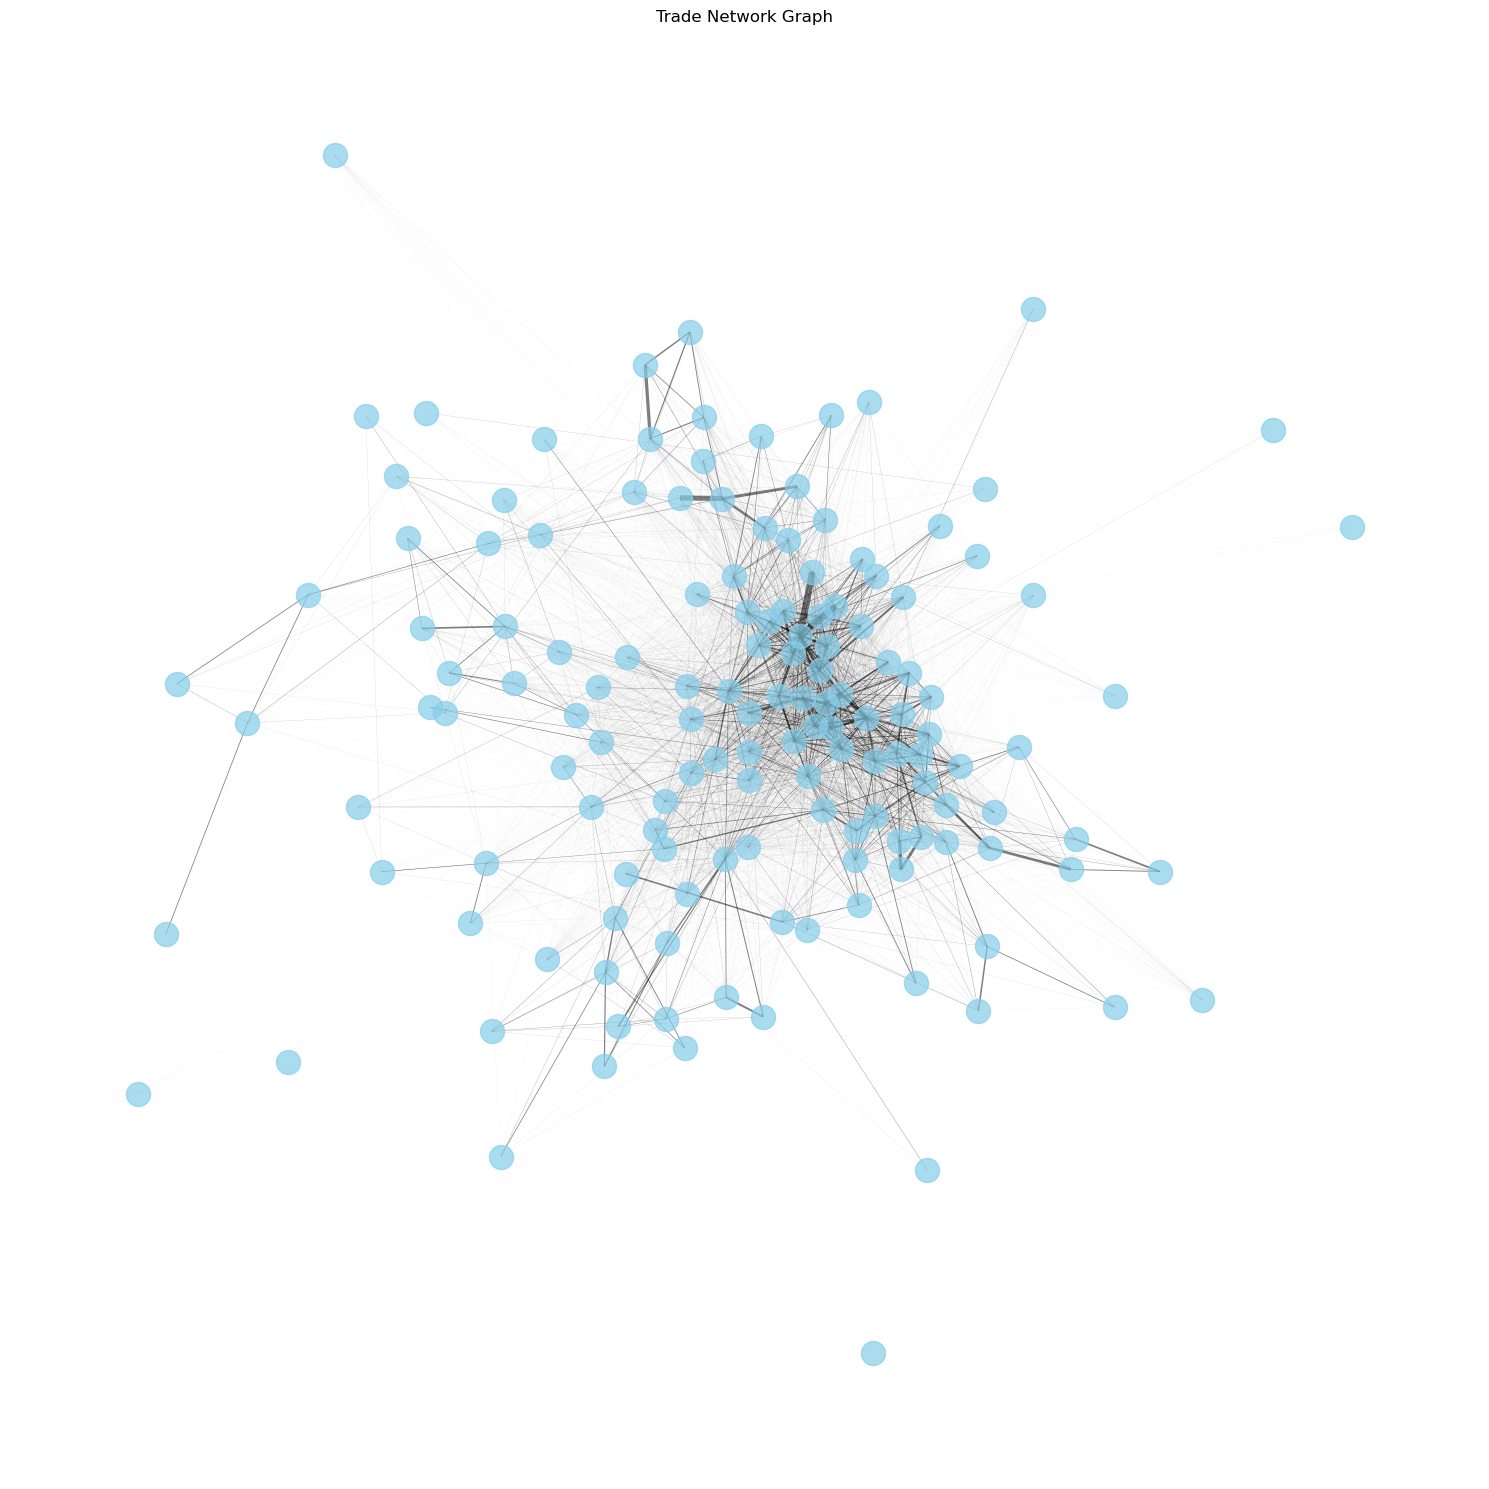

Graph plotted and saved as ./trade/trade_graph.png.


In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def create_graphml_and_plot(csv_file, graphml_file, plot_file, weight_threshold=1e-6):
    """
    Creates a GraphML file from a normalized adjacency matrix and plots the graph.
    
    Parameters:
    - csv_file (str): Path to the input CSV file containing the normalized adjacency matrix.
    - graphml_file (str): Path to save the output GraphML file.
    - plot_file (str): Path to save the plotted graph image.
    - weight_threshold (float): Minimum weight to consider; edges below this are removed.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file, index_col=0)
    print(f"Loaded adjacency matrix with shape {df.shape}.")
    
    # Create graph from adjacency matrix
    G = nx.from_pandas_adjacency(df, create_using=nx.Graph)
    print(f"Initial graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
    # Remove edges below the weight threshold
    if weight_threshold > 0:
        edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < weight_threshold]
        G.remove_edges_from(edges_to_remove)
        print(f"Removed {len(edges_to_remove)} edges below the weight threshold of {weight_threshold}.")
    
    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    print(f"Removed {len(isolated_nodes)} isolated nodes.")
    
    # Save the graph as GraphML
    nx.write_graphml(G, graphml_file)
    print(f"Graph saved as {graphml_file}.")
    
    # Plot the graph
    plt.figure(figsize=(15, 15))
    
    # Choose layout
    pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)
    
    # Extract edge weights for plotting
    edges = G.edges(data=True)
    weights = [d['weight'] for _, _, d in edges]
    
    # Normalize edge widths for better visualization
    max_weight = max(weights) if weights else 1
    normalized_weights = [5 * (w / max_weight) for w in weights]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.5)
    
    # Draw labels for a smaller graph
    if G.number_of_nodes() <= 100:
        nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("Trade Network Graph")
    plt.axis('off')
    plt.tight_layout()
    
    # Save the plotted graph
    plt.savefig(plot_file, dpi=300)
    plt.show()
    print(f"Graph plotted and saved as {plot_file}.")

# Example usage
if __name__ == "__main__":
    csv_input = "./trade/trade_matrix_normalized.csv"       # Input CSV file path
    graphml_output = "./trade/trade_graph.graphml"         # Output GraphML file path
    plot_output = "./trade/trade_graph.png"                # Output plot image file path
    
    create_graphml_and_plot(csv_input, graphml_output, plot_output)

Loaded adjacency matrix with shape (246, 246).
Initial graph has 246 nodes and 7564 edges.
Removed 0 edges below the weight threshold of 1e-06.
Removed 102 isolated nodes.
Graph saved as ./trade/trade_graph.graphml.


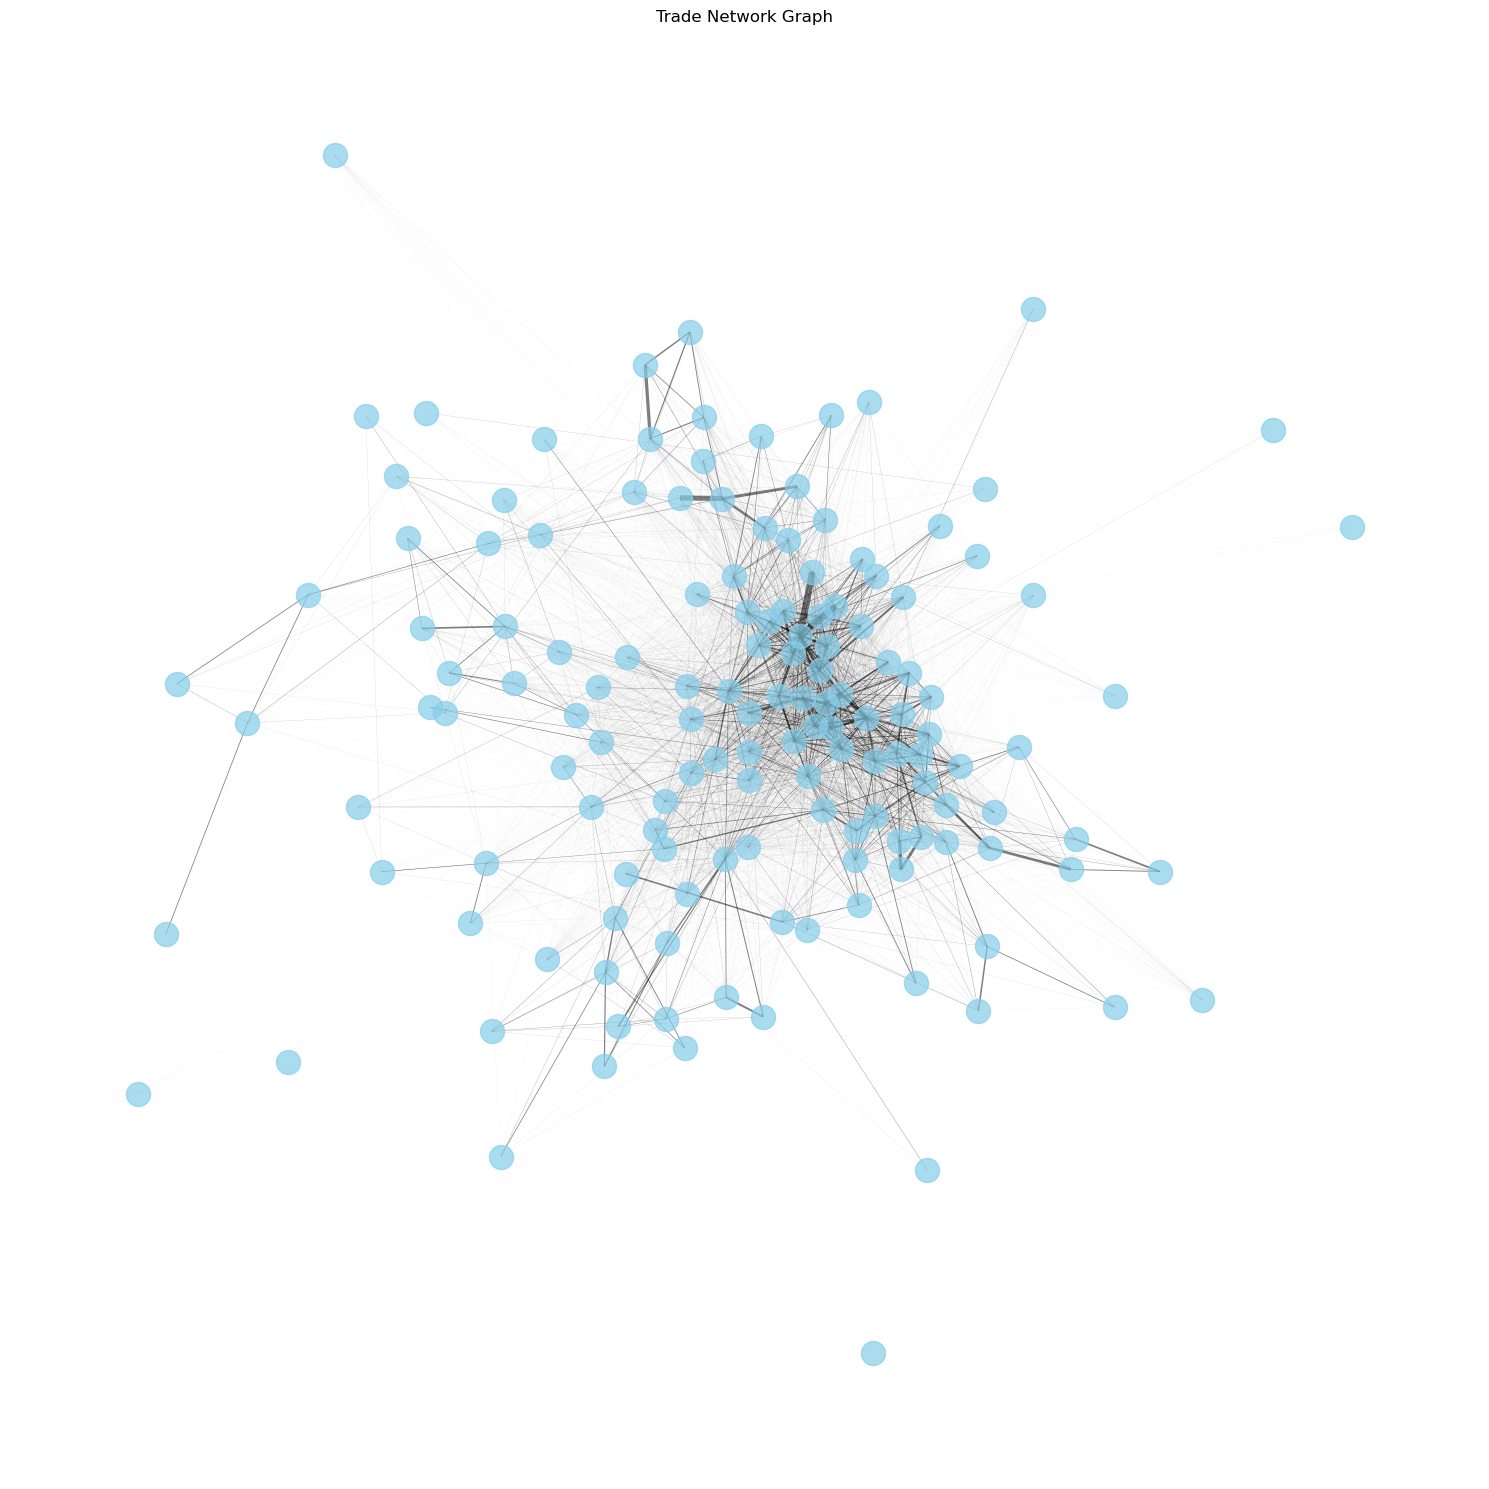

Graph plotted and saved as ./trade/trade_graph.png.
Detecting communities...


/home/rohit/anaconda3/envs/gt/lib/python3.12/site-packages/graph_tool/inference/blockmodel.py:389: UserWarning: unrecognized keyword arguments: ['weight']
  warnings.warn("unrecognized keyword arguments: " +



Analyzing communities...

Community Statistics:
Total number of communities: 6
Total number of nodes: 144

Detailed community breakdown:

Community 0:
Size: 67 nodes
Density: 0.983
Average correlation: 0.007
Members: Argentina, Australia, Austria, Belgium, Brazil, Bulgaria, Canada, Chile, China, Colombia, Croatia, Cyprus, Czech Republic, Denmark, Egypt, Estonia, European Union, Finland, France, Germany, Ghana, Greece, Hong Kong, Hungary, India, Indonesia, Ireland, Israel, Italy, Japan, Kenya, Latvia, Lebanon, Lithuania, Luxembourg, Malaysia, Malta, Mauritius, Morocco, Netherlands, New Zealand, Norway, Oman, Other Asia, Pakistan, Peru, Philippines, Poland, Portugal, Romania, Senegal, Singapore, Slovak Republic, Slovenia, South Africa, Spain, Sri Lanka, Sweden, Switzerland, Thailand, Turkey, Ukraine, United Arab Emirates, United Kingdom, United States, Uruguay, Vietnam

Community 1:
Size: 9 nodes
Density: 0.917
Average correlation: 0.001
Members: Bahrain, Cambodia, Georgia, Jordan, Kuwa

/tmp/ipykernel_3309905/2191436047.py:127: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'members': comm_df.groupby('Community').apply(lambda x: list(x.index))


Network visualization saved as ./trade/communities_visualization.png
Plotting dendrogram...
Dendrogram saved as ./trade/dendrogram.png.


In [6]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graph_tool.all as gt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram


class WSBMCommunityDetector:
    def __init__(self, graph_file):
        """
        Initialize the WSBMCommunityDetector with a GraphML file.

        Args:
            graph_file (str): Path to the GraphML file containing the network.
        """
        if not os.path.exists(graph_file):
            raise FileNotFoundError(f"The file {graph_file} does not exist.")

        # Load the graph using NetworkX
        self.graph = nx.read_graphml(graph_file)

        # Ensure that the graph is undirected
        if self.graph.is_directed():
            self.graph = self.graph.to_undirected()
            print("Converted directed graph to undirected.")

        # Remove self-loops if any
        self.graph.remove_edges_from(nx.selfloop_edges(self.graph))

        # Convert weight attributes to float if they're stored as strings
        for u, v, d in self.graph.edges(data=True):
            if 'weight' in d:
                try:
                    d['weight'] = float(d['weight'])
                except ValueError:
                    d['weight'] = 1.0  # Default weight if conversion fails
                    print(f"Non-numeric weight on edge ({u}, {v}). Set to default 1.0.")
            else:
                d['weight'] = 1.0  # Default weight if not present

    def detect_communities_graphtool(self, n_blocks=None, nested=True):
        """
        Detect communities using graph-tool's WSBM implementation.

        Args:
            n_blocks (int, optional): Specify the number of communities.
                                      If None and nested=True, the nested block model is used to infer the number.
            nested (bool): Whether to use a nested block model. If False and n_blocks is None,
                           a default number of blocks is used.

        Returns:
            communities (dict): Mapping from node to community.
            state (graph_tool.BlockState): The state object after optimization.
        """
        # Convert NetworkX graph to graph-tool format
        gt_graph = gt.Graph(directed=False)

        # Add vertices
        node_mapping = {}
        reverse_mapping = {}
        for node in self.graph.nodes():
            v = gt_graph.add_vertex()
            node_mapping[node] = v
            reverse_mapping[int(v)] = node  # For reverse lookup

        # Create edge weights property map
        edge_weights = gt_graph.new_edge_property("double")
        gt_graph.edge_properties["weight"] = edge_weights

        # Add edges with weights
        for u, v, data in self.graph.edges(data=True):
            e = gt_graph.add_edge(node_mapping[u], node_mapping[v])
            edge_weights[e] = data.get('weight', 1.0)

        # Check if edge weights are non-negative
        if np.any([w < 0 for w in edge_weights.a]):
            raise ValueError("Edge weights must be non-negative.")

        # Community Detection
        if nested and n_blocks is None:
            # Use nested block model to infer the number of communities
            state = gt.minimize_nested_blockmodel_dl(gt_graph, state_args={"weight": edge_weights})
            blocks = state.get_bs()[0]  # Get the lowest level blocks
        elif n_blocks is not None:
            # Use a regular block model with specified number of communities
            state = gt.BlockState(gt_graph, B=n_blocks, weight=edge_weights)
            # Perform MCMC sweeps to optimize
            for _ in range(1000):
                state.mcmc_sweep(beta=np.inf)
            blocks = state.get_blocks()
        else:
            # Use a regular block model with a default number of blocks
            state = gt.minimize_blockmodel_dl(gt_graph, state_args={"weight": edge_weights})
            blocks = state.get_blocks()

        # Map community assignments back to original node labels
        communities = {}
        for v in range(gt_graph.num_vertices()):
            node = reverse_mapping[v]
            communities[node] = int(blocks[v])

        # Relabel communities to start from 0 and be consecutive
        unique_communities = sorted(set(communities.values()))
        community_map = {comm: idx for idx, comm in enumerate(unique_communities)}
        communities = {node: community_map[comm] for node, comm in communities.items()}

        return communities, state

    def analyze_communities(self, communities):
        """
        Analyze the detected communities.

        Args:
            communities (dict): Mapping from node to community.

        Returns:
            stats (dict): Dictionary containing community statistics.
        """
        comm_df = pd.DataFrame.from_dict(communities, orient='index', columns=['Community'])

        # Calculate community sizes and members
        stats = {
            'size': comm_df['Community'].value_counts().sort_index(),
            'members': comm_df.groupby('Community').apply(lambda x: list(x.index))
        }

        # Calculate internal density and average edge weight for each community
        densities = {}
        avg_weights = {}
        for comm in stats['size'].index:
            members = stats['members'][comm]
            subgraph = self.graph.subgraph(members)
            densities[comm] = nx.density(subgraph)

            # Calculate average edge weight within community
            weights = [d['weight'] for u, v, d in subgraph.edges(data=True)]
            avg_weights[comm] = np.mean(weights) if weights else 0.0

        stats['density'] = pd.Series(densities)
        stats['avg_weight'] = pd.Series(avg_weights)

        return stats

    def visualize_communities(self, communities, state, output_file='communities.png'):
        """
        Visualize the communities with hierarchical clustering.

        Args:
            communities (dict): Mapping from node to community.
            state (graph_tool.BlockState): The state object after optimization.
            output_file (str): Filename for saving the visualization.
        """
        plt.figure(figsize=(20, 20))

        # Create a mapping from community to members
        comm_to_members = {}
        for node, comm in communities.items():
            comm_to_members.setdefault(comm, set()).add(node)

        unique_communities = sorted(set(communities.values()))
        n_comms = len(unique_communities)

        # Initialize affinity matrix based on shared members
        affinity_matrix = np.zeros((n_comms, n_comms))

        for i in unique_communities:
            for j in unique_communities:
                if i == j:
                    affinity_matrix[i, j] = len(comm_to_members[i])
                else:
                    # Compute the number of shared nodes (intersection)
                    intersection = comm_to_members[i].intersection(comm_to_members[j])
                    affinity_matrix[i, j] = len(intersection)

        # Normalize affinity matrix to [0,1]
        max_affinity = affinity_matrix.max()
        if max_affinity > 0:
            affinity_matrix_normalized = affinity_matrix / max_affinity
        else:
            affinity_matrix_normalized = affinity_matrix

        # Compute distance matrix: higher affinity -> smaller distance
        distance_matrix = 1 - affinity_matrix_normalized

        # Ensure diagonal is zero
        np.fill_diagonal(distance_matrix, 0.0)

        # Perform hierarchical clustering for dendrogram
        try:
            condensed_dist = squareform(distance_matrix)
            Z = linkage(condensed_dist, method='average')
        except ValueError as e:
            print(f"Error during hierarchical clustering: {e}")
            condensed_dist = squareform(distance_matrix, checks=False)
            Z = linkage(condensed_dist, method='average')

        # Convert NetworkX graph to position dictionary
        pos = nx.spring_layout(self.graph, k=1.5/np.sqrt(len(self.graph.nodes())),
                               iterations=50, seed=42)

        # Create color map
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        color_map = dict(zip(unique_communities, colors))

        # Draw edges first with transparency based on weight
        edge_weights = [d['weight'] for (u, v, d) in self.graph.edges(data=True)]
        max_weight = max(edge_weights) if edge_weights else 1.0
        normalized_weights = [w / max_weight for w in edge_weights]

        nx.draw_networkx_edges(self.graph, pos,
                               alpha=0.2,
                               width=normalized_weights)

        # Draw nodes for each community
        for comm in unique_communities:
            node_list = [node for node, c in communities.items() if c == comm]
            nx.draw_networkx_nodes(self.graph, pos,
                                   nodelist=node_list,
                                   node_color=[color_map[comm]],
                                   node_size=300,
                                   label=f'Community {comm} ({len(node_list)} nodes)')

        # Add labels with smaller font
        nx.draw_networkx_labels(self.graph, pos, font_size=6)

        plt.title("Detected Communities via WSBM")
        plt.axis('off')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

        # Save with high resolution
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Community visualization saved as {output_file}.")

    def plot_dendrogram(self, communities, output_file='dendrogram.png'):
        """
        Plot a dendrogram based on community similarities.

        Args:
            communities (dict): Mapping from node to community.
            output_file (str): Filename for saving the dendrogram.
        """
        # Create a mapping from community to members
        comm_to_members = {}
        for node, comm in communities.items():
            comm_to_members.setdefault(comm, set()).add(node)

        unique_communities = sorted(set(communities.values()))
        n_comms = len(unique_communities)

        # Initialize affinity matrix based on shared members
        affinity_matrix = np.zeros((n_comms, n_comms))

        for i in unique_communities:
            for j in unique_communities:
                if i == j:
                    affinity_matrix[i, j] = len(comm_to_members[i])
                else:
                    # Compute the number of shared nodes (intersection)
                    intersection = comm_to_members[i].intersection(comm_to_members[j])
                    affinity_matrix[i, j] = len(intersection)

        # Normalize affinity matrix to [0,1]
        max_affinity = affinity_matrix.max()
        if max_affinity > 0:
            affinity_matrix_normalized = affinity_matrix / max_affinity
        else:
            affinity_matrix_normalized = affinity_matrix

        # Compute distance matrix: higher affinity -> smaller distance
        distance_matrix = 1 - affinity_matrix_normalized

        # Ensure diagonal is zero
        np.fill_diagonal(distance_matrix, 0.0)

        # Convert to condensed distance matrix
        try:
            condensed_dist = squareform(distance_matrix)
            Z = linkage(condensed_dist, method='average')
        except ValueError as e:
            print(f"Error during dendrogram plotting: {e}")
            condensed_dist = squareform(distance_matrix, checks=False)
            Z = linkage(condensed_dist, method='average')

        # Prepare community labels
        comm_labels = [f'Comm {comm}' for comm in unique_communities]

        # Plot the dendrogram
        plt.figure(figsize=(15, 7))
        dendrogram(Z, labels=comm_labels, leaf_rotation=90)
        plt.title("Dendrogram of Detected Communities")
        plt.xlabel("Community")
        plt.ylabel("Distance")
        plt.tight_layout()
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Dendrogram saved as {output_file}.")


    # Modified visualization method
    def visualize_communities_on_map(self, communities, output_file='community_world_map.png'):
        """Visualize communities on world map using downloaded natural earth data"""
        # Ensure trade directory exists
        os.makedirs('./trade', exist_ok=True)
        
        # Get world map data
        world_file = download_natural_earth_data()
        world = gpd.read_file(world_file)
        
        # Create color mapping
        unique_communities = sorted(set(communities.values()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        color_map = {comm: rgb2hex(colors[i]) for i, comm in enumerate(unique_communities)}
        
        # Map communities to countries
        country_communities = {}
        for node, comm in communities.items():
            country = node.split('.')[0] if '.' in node else node
            country_communities[country] = comm
        
        # Map colors to countries
        world['colors'] = world['NAME'].map(lambda x: color_map.get(country_communities.get(x, -1), '#lightgray'))
        
        # Plot
        fig, ax = plt.subplots(figsize=(20, 10))
        world.plot(color=world['colors'], ax=ax)
        
        # Add legend
        patches = [plt.Rectangle((0,0),1,1, fc=color_map[comm]) for comm in unique_communities]
        plt.legend(patches, 
                [f'Community {comm} ({list(communities.values()).count(comm)} members)' 
                for comm in unique_communities],
                loc='center left', 
                bbox_to_anchor=(1, 0.5))
        
        plt.title('Trade Communities World Map')
        plt.axis('off')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"World map visualization saved as {output_file}")

    # Modified visualization method (replace existing visualize_communities method)
    def visualize_communities(self, communities, state, output_file='communities.png'):
        """
        Visualize the communities with enhanced layout and colors.
        
        Args:
            communities (dict): Mapping from node to community.
            state: The block state object (unused but kept for compatibility).
            output_file (str): Path to save the visualization.
        """
        plt.figure(figsize=(20, 20))
        
        # Create color mapping
        unique_communities = sorted(set(communities.values()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        color_map = dict(zip(unique_communities, colors))
        
        # Improved layout
        pos = nx.spring_layout(self.graph, 
                            k=2/np.sqrt(len(self.graph.nodes())),
                            iterations=100, 
                            seed=42)
        
        # Draw edges with minimal visibility
        nx.draw_networkx_edges(self.graph, pos, 
                            alpha=0.2, 
                            width=0.5)
        
        # Draw nodes for each community
        for comm in unique_communities:
            node_list = [node for node, c in communities.items() if c == comm]
            nx.draw_networkx_nodes(self.graph, pos,
                                nodelist=node_list,
                                node_color=[color_map[comm]],
                                node_size=500,
                                label=f'Community {comm} ({len(node_list)} members)')
        
        # Add labels with better positioning
        labels = {node: node.split('.')[0] for node in self.graph.nodes()}
        nx.draw_networkx_labels(self.graph, pos, 
                            labels, 
                            font_size=8)
        
        plt.title("Trade Communities Network")
        plt.axis('off')
        plt.legend(bbox_to_anchor=(1.05, 1), 
                loc='upper left', 
                fontsize=10)
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Network visualization saved as {output_file}")

def create_graphml_and_plot(csv_file, graphml_file, plot_file, weight_threshold=1e-6):
    """
    Creates a GraphML file from a normalized adjacency matrix and plots the graph.

    Parameters:
    - csv_file (str): Path to the input CSV file containing the normalized adjacency matrix.
    - graphml_file (str): Path to save the output GraphML file.
    - plot_file (str): Path to save the plotted graph image.
    - weight_threshold (float): Minimum weight to consider; edges below this are removed.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file, index_col=0)
    print(f"Loaded adjacency matrix with shape {df.shape}.")

    # Create graph from adjacency matrix
    G = nx.from_pandas_adjacency(df, create_using=nx.Graph)
    print(f"Initial graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Remove edges below the weight threshold
    if weight_threshold > 0:
        edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < weight_threshold]
        G.remove_edges_from(edges_to_remove)
        print(f"Removed {len(edges_to_remove)} edges below the weight threshold of {weight_threshold}.")

    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    print(f"Removed {len(isolated_nodes)} isolated nodes.")

    # Save the graph as GraphML
    nx.write_graphml(G, graphml_file)
    print(f"Graph saved as {graphml_file}.")

    # Plot the graph
    plt.figure(figsize=(15, 15))

    # Choose layout
    pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)

    # Extract edge weights for plotting
    edges = G.edges(data=True)
    weights = [d['weight'] for _, _, d in edges]

    # Normalize edge widths for better visualization
    max_weight = max(weights) if weights else 1
    normalized_weights = [5 * (w / max_weight) for w in weights]

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.7)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.5)

    # Draw labels for a smaller graph
    if G.number_of_nodes() <= 100:
        nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Trade Network Graph")
    plt.axis('off')
    plt.tight_layout()

    # Save the plotted graph
    plt.savefig(plot_file, dpi=300)
    plt.show()
    print(f"Graph plotted and saved as {plot_file}.")

# Example usage
if __name__ == "__main__":
    # Generate GraphML and plot
    csv_input = "./trade/trade_matrix_normalized.csv"       # Input CSV file path
    graphml_output = "./trade/trade_graph.graphml"         # Output GraphML file path
    plot_output = "./trade/trade_graph.png"                # Output plot image file path

    create_graphml_and_plot(csv_input, graphml_output, plot_output)

    # Initialize detector with your graph file
    detector = WSBMCommunityDetector("./trade/trade_graph.graphml")

    # Detect communities
    print("Detecting communities...")
    communities, state = detector.detect_communities_graphtool(n_blocks=None)

    # Analyze communities
    print("\nAnalyzing communities...")
    stats = detector.analyze_communities(communities)

    # Print detailed statistics
    print("\nCommunity Statistics:")
    print(f"Total number of communities: {len(stats['size'])}")
    print(f"Total number of nodes: {sum(stats['size'])}")
    print("\nDetailed community breakdown:")
    for comm in stats['size'].index:
        print(f"\nCommunity {comm}:")
        print(f"Size: {stats['size'][comm]} nodes")
        print(f"Density: {stats['density'][comm]:.3f}")
        print(f"Average correlation: {stats['avg_weight'][comm]:.3f}")
        print("Members:", ", ".join(stats['members'][comm]))

    # Save communities to CSV
    comm_df = pd.DataFrame.from_dict(communities, orient='index', columns=['Community'])
    comm_df.to_csv('./trade/communities.csv')
    print("\nCommunity assignments saved to 'communities.csv'.")

    # Create visualization
    print("\nCreating visualization...")
    detector.visualize_communities(communities, state, output_file='./trade/communities_visualization.png')

    # Plot dendrogram
    print("Plotting dendrogram...")
    detector.plot_dendrogram(communities, output_file='./trade/dendrogram.png')

In [7]:
# After detecting communities
#detector.visualize_communities_on_map(communities, './trade/community_world_map.png')
detector.visualize_communities(communities, state, './trade/communities_network.png')
detector.plot_dendrogram(communities, './trade/community_hierarchy.png')

Network visualization saved as ./trade/communities_network.png
Dendrogram saved as ./trade/community_hierarchy.png.


In [8]:
# add every country to a list irrespective of community
countries = []
for country in communities.keys():
    countries.append(country)

print(countries )


['Albania', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Barbados', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Canada', 'Cape Verde', 'Central African Republic', 'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica', 'Cote dIvoire', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Ethiopia(excludes Eritrea)', 'European Union', 'Fiji', 'Finland', 'France', 'French Polynesia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Lesotho', 'Lithuania', 'Luxembourg', 'Macao', 'Madagascar', 'M

In [29]:
def create_country_mapping():
    """Create mapping between dataset countries and Natural Earth names"""
    # First, create direct mappings for sovereign states
    mapping = {
        'Andorra': 'Andorra',
        'Antigua and Barbuda': 'Antigua and Barbuda',
        'Bahrain': 'Bahrain',
        'Barbados': 'Barbados',
        'Bosnia and Herzegovina': 'Bosnia and Herz.',
        'Cape Verde': 'Cabo Verde',
        'Central African Republic': 'Central African Rep.',
        'Cote dIvoire': "Côte d'Ivoire",
        'Czech Republic': 'Czechia',
        'Dominican Republic': 'Dominican Rep.',
        'East Timor': 'Timor-Leste',
        'Ethiopia(excludes Eritrea)': 'Ethiopia',
        'European Union': None,  # Skip
        'Grenada': 'Grenada',
        'Kyrgyz Republic': 'Kyrgyzstan',
        'Maldives': 'Maldives',
        'Malta': 'Malta',
        'Mauritius': 'Mauritius',
        'Occ.Pal.Terr': 'Palestine',
        'Other Asia': 'Taiwan',
        'Sao Tome and Principe': 'Sao Tome and Principe',
        'Seychelles': 'Seychelles',
        'Singapore': 'Singapore',
        'Slovak Republic': 'Slovakia',
        'United States': 'United States of America'
    }
    
    # Create separate mapping for territories to handle them differently
    territory_mapping = {
        'Aruba': 'Netherlands',
        'Bermuda': 'United Kingdom',
        'French Polynesia': 'France',
        'Hong Kong': 'Hong Kong',  # Keep separate
        'Macao': 'Macao',  # Keep separate
        'Montserrat': 'United Kingdom'
    }
    
    return mapping, territory_mapping



In [30]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graph_tool.all as gt
import geopandas as gpd
from matplotlib.colors import rgb2hex
import requests
import zipfile
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.filterwarnings('ignore')
def get_natural_earth_data():
    """Download and cache Natural Earth data"""
    # Define paths
    data_dir = Path('./data')
    shp_path = data_dir / 'ne_110m_admin_0_countries.shp'
    
    # Return cached data if exists
    if shp_path.exists():
        return str(shp_path)
        
    # Create data directory
    data_dir.mkdir(exist_ok=True)
    
    # Download data
    url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip"
    zip_path = data_dir / 'natural_earth_data.zip'
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        # Save and extract zip file
        zip_path.write_bytes(response.content)
        with zipfile.ZipFile(zip_path) as z:
            z.extractall(data_dir)
            
        # Cleanup
        zip_path.unlink()
        return str(shp_path)
        
    except Exception as e:
        raise RuntimeError(f"Failed to download Natural Earth data: {e}")

class WSBMCommunityDetector:
    def __init__(self, graph_file):
        if not os.path.exists(graph_file):
            raise FileNotFoundError(f"The file {graph_file} does not exist.")

        self.graph = nx.read_graphml(graph_file)
        if self.graph.is_directed():
            self.graph = self.graph.to_undirected()
        
        self.graph.remove_edges_from(nx.selfloop_edges(self.graph))
        
        for u, v, d in self.graph.edges(data=True):
            if 'weight' in d:
                try:
                    d['weight'] = float(d['weight'])
                except ValueError:
                    d['weight'] = 1.0
            else:
                d['weight'] = 1.0

    def detect_communities_graphtool(self, n_blocks=None, nested=True):
        gt_graph = gt.Graph(directed=False)
        
        node_mapping = {}
        reverse_mapping = {}
        for node in self.graph.nodes():
            v = gt_graph.add_vertex()
            node_mapping[node] = v
            reverse_mapping[int(v)] = node

        edge_weights = gt_graph.new_edge_property("double")
        gt_graph.edge_properties["weight"] = edge_weights

        for u, v, data in self.graph.edges(data=True):
            e = gt_graph.add_edge(node_mapping[u], node_mapping[v])
            edge_weights[e] = data.get('weight', 1.0)

        if np.any([w < 0 for w in edge_weights.a]):
            raise ValueError("Edge weights must be non-negative.")

        if nested and n_blocks is None:
            state = gt.minimize_nested_blockmodel_dl(gt_graph, state_args={"weight": edge_weights})
            blocks = state.get_bs()[0]
        elif n_blocks is not None:
            state = gt.BlockState(gt_graph, B=n_blocks, weight=edge_weights)
            for _ in range(1000):
                state.mcmc_sweep(beta=np.inf)
            blocks = state.get_blocks()
        else:
            state = gt.minimize_blockmodel_dl(gt_graph, state_args={"weight": edge_weights})
            blocks = state.get_blocks()

        communities = {}
        for v in range(gt_graph.num_vertices()):
            node = reverse_mapping[v]
            communities[node] = int(blocks[v])

        unique_communities = sorted(set(communities.values()))
        community_map = {comm: idx for idx, comm in enumerate(unique_communities)}
        communities = {node: community_map[comm] for node, comm in communities.items()}

        return communities, state

    def analyze_communities(self, communities):
        comm_df = pd.DataFrame.from_dict(communities, orient='index', columns=['Community'])
        
        stats = {
            'size': comm_df['Community'].value_counts().sort_index(),
            'members': comm_df.groupby('Community').apply(lambda x: list(x.index))
        }
        
        densities = {}
        avg_weights = {}
        for comm in stats['size'].index:
            members = stats['members'][comm]
            subgraph = self.graph.subgraph(members)
            densities[comm] = nx.density(subgraph)
            weights = [d['weight'] for u, v, d in subgraph.edges(data=True)]
            avg_weights[comm] = np.mean(weights) if weights else 0.0

        stats['density'] = pd.Series(densities)
        stats['avg_weight'] = pd.Series(avg_weights)
        return stats

    def plot_dendrogram(self, communities, output_file='dendrogram.png', show=True):
        fig = self._create_dendrogram(communities)
        if output_file:
            fig.savefig(output_file, dpi=300, bbox_inches='tight')
        if show:
            plt.show()
        else:
            plt.close()

    def visualize_communities(self, communities, state, output_file='communities.png', show=True):
        fig = self._create_network_viz(communities)
        if output_file:
            fig.savefig(output_file, dpi=300, bbox_inches='tight')
        if show:
            plt.show()
        else:
            plt.close()

    def visualize_communities_on_map(self, communities, output_file='./trade/community_world_map.png', show=False):
        """Visualize communities on world map"""
        # Ensure output directory exists
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        
        # Load world map data
        world = gpd.read_file(get_natural_earth_data())
        
        # Get both mappings
        country_mapping, territory_mapping = create_country_mapping()
        
        # Create color mapping for communities
        unique_communities = sorted(set(communities.values()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        color_map = {comm: rgb2hex(colors[i]) for i, comm in enumerate(unique_communities)}
        
        # Map communities to countries, handling territories separately
        country_communities = {}
        for node, comm in communities.items():
            country = node.split('.')[0] if '.' in node else node
            
            # Handle territories separately to preserve their communities
            if country in territory_mapping:
                mapped_country = territory_mapping[country]
                if mapped_country != country:  # If it's mapped to a sovereign state
                    continue  # Skip to avoid overwriting the sovereign state's community
            else:
                mapped_country = country_mapping.get(country, country)
                
            if mapped_country:
                country_communities[mapped_country] = comm
        
        # Create colors column with proper default color
        default_color = '#D3D3D3'  # Light gray
        world['color_column'] = world['NAME'].map(
            lambda x: color_map.get(country_communities.get(x, -1), default_color)
        )
        
        # Create plot
        fig, ax = plt.subplots(figsize=(20, 10))
        world.plot(color=world['color_column'], ax=ax)
        
        # Add legend
        patches = [plt.Rectangle((0,0),1,1, fc=color_map[comm]) for comm in unique_communities]
        plt.legend(patches, 
                [f'Community {comm} ({list(communities.values()).count(comm)} members)' 
                for comm in unique_communities],
                loc='center left', 
                bbox_to_anchor=(1, 0.5))
        
        plt.title('Trade Communities World Map')
        plt.axis('off')
        
        # Save and/or show plot
        if output_file:
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"World map visualization saved as {output_file}")
        
        if show:
            plt.show()
        else:
            plt.close()

    def _create_dendrogram(self, communities):
        comm_to_members = {}
        for node, comm in communities.items():
            comm_to_members.setdefault(comm, set()).add(node)
        
        unique_communities = sorted(set(communities.values()))
        n_comms = len(unique_communities)
        
        similarity_matrix = np.zeros((n_comms, n_comms))
        for i, comm1 in enumerate(unique_communities):
            for j, comm2 in enumerate(unique_communities):
                members1 = comm_to_members[comm1]
                members2 = comm_to_members[comm2]
                similarity = len(members1.intersection(members2)) / len(members1.union(members2))
                similarity_matrix[i, j] = similarity
        
        distance_matrix = 1 - similarity_matrix
        Z = linkage(squareform(distance_matrix), method='ward')
        
        plt.figure(figsize=(12, 8))
        dendrogram(
            Z,
            labels=[f'Community {c}\n({len(comm_to_members[c])} members)' for c in unique_communities],
            leaf_rotation=90,
            leaf_font_size=10
        )
        plt.title("Community Hierarchy Dendrogram")
        plt.tight_layout()
        return plt.gcf()

    def _create_network_viz(self, communities):
        plt.figure(figsize=(15, 15))
        
        pos = nx.spring_layout(self.graph, k=2, iterations=100, seed=42)
        
        edge_weights = [d['weight'] for (_, _, d) in self.graph.edges(data=True)]
        max_weight = max(edge_weights)
        edge_widths = [2 * (w / max_weight) for w in edge_weights]
        
        unique_communities = sorted(set(communities.values()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        
        nx.draw_networkx_edges(self.graph, pos, 
                              width=edge_widths,
                              alpha=0.3,
                              edge_color='gray')
        
        for comm_idx, comm in enumerate(unique_communities):
            node_list = [node for node, c in communities.items() if c == comm]
            nx.draw_networkx_nodes(self.graph, pos,
                                 nodelist=node_list,
                                 node_color=[colors[comm_idx]],
                                 node_size=300,
                                 label=f'Community {comm} ({len(node_list)})')
        
        labels = {node: node.split('.')[0] for node in self.graph.nodes()}
        nx.draw_networkx_labels(self.graph, pos, labels,
                              font_size=8,
                              font_weight='bold')
        
        plt.title("Trade Communities Network", pad=20)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return plt.gcf()

    def _create_map_viz(self, communities):
        world = gpd.read_file(self._download_natural_earth_data())
        
        unique_communities = sorted(set(communities.values()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))
        color_map = {comm: rgb2hex(colors[i]) for i, comm in enumerate(unique_communities)}
        
        country_communities = {}
        for node, comm in communities.items():
            country = node.split('.')[0] if '.' in node else node
            country_communities[country] = comm
        
        fig, ax = plt.subplots(figsize=(20, 10))
        
        world['colors'] = world['NAME'].map(lambda x: color_map.get(country_communities.get(x, -1), '#f0f0f0'))
        world.plot(color=world['colors'], ax=ax)
        
        patches = [plt.Rectangle((0,0), 1, 1, fc=color_map[comm]) 
                  for comm in unique_communities]
        plt.legend(patches,
                  [f'Community {comm} ({list(communities.values()).count(comm)})' 
                   for comm in unique_communities],
                  loc='center left',
                  bbox_to_anchor=(1, 0.5))
        
        plt.title('Trade Communities World Map')
        plt.axis('off')
        return plt.gcf()

    @staticmethod
    def _download_natural_earth_data():
        data_dir = './data'
        shp_file = f'{data_dir}/ne_110m_admin_0_countries.shp'
        
        if os.path.exists(shp_file):
            return shp_file
            
        os.makedirs(data_dir, exist_ok=True)
        
        url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
        zip_path = f'{data_dir}/ne_110m_admin_0_countries.zip'
        
        print("Downloading Natural Earth data...")
        response = requests.get(url)
        response.raise_for_status()
        
        with open(zip_path, 'wb') as f:
            f.write(response.content)
            
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        
        return shp_file


Community Statistics:
Total communities: 6
Total nodes: 144


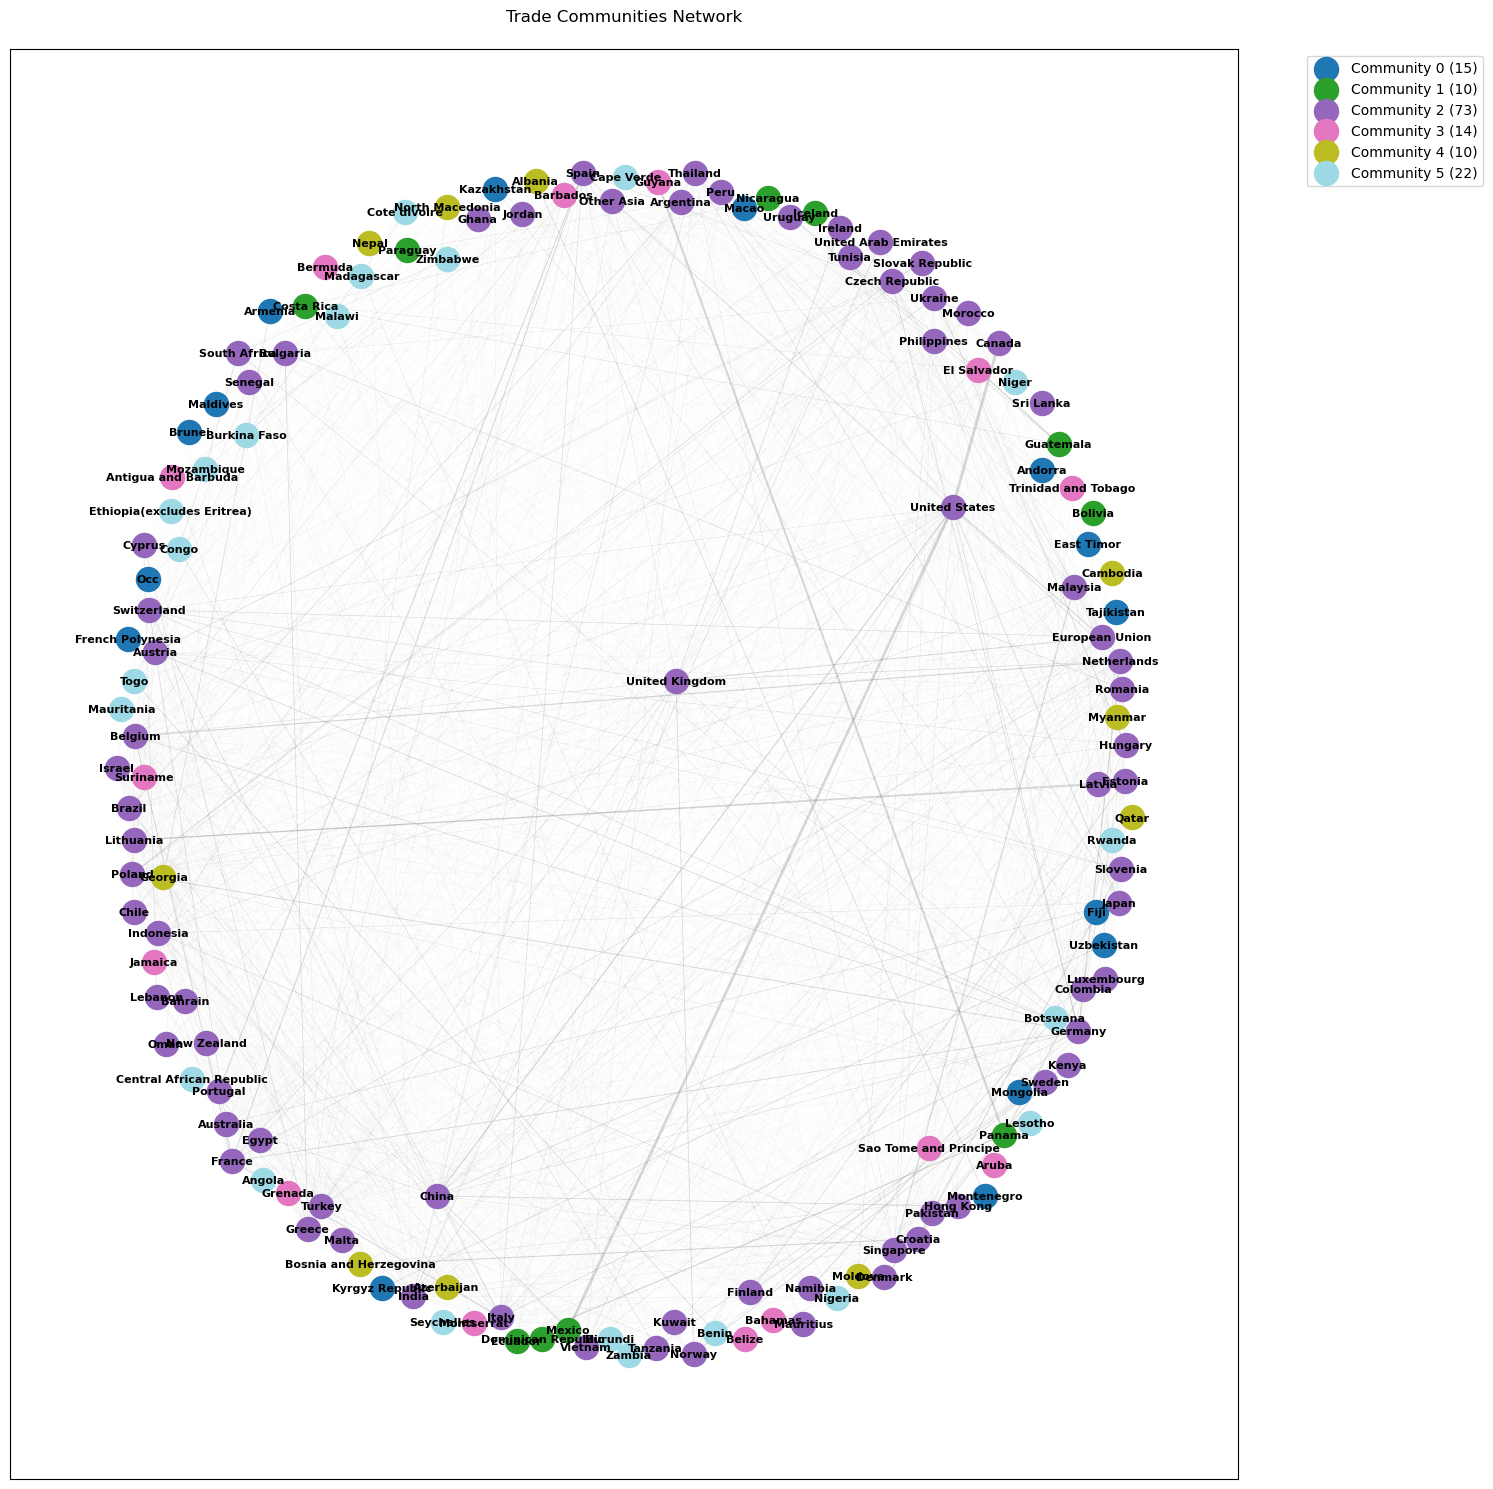

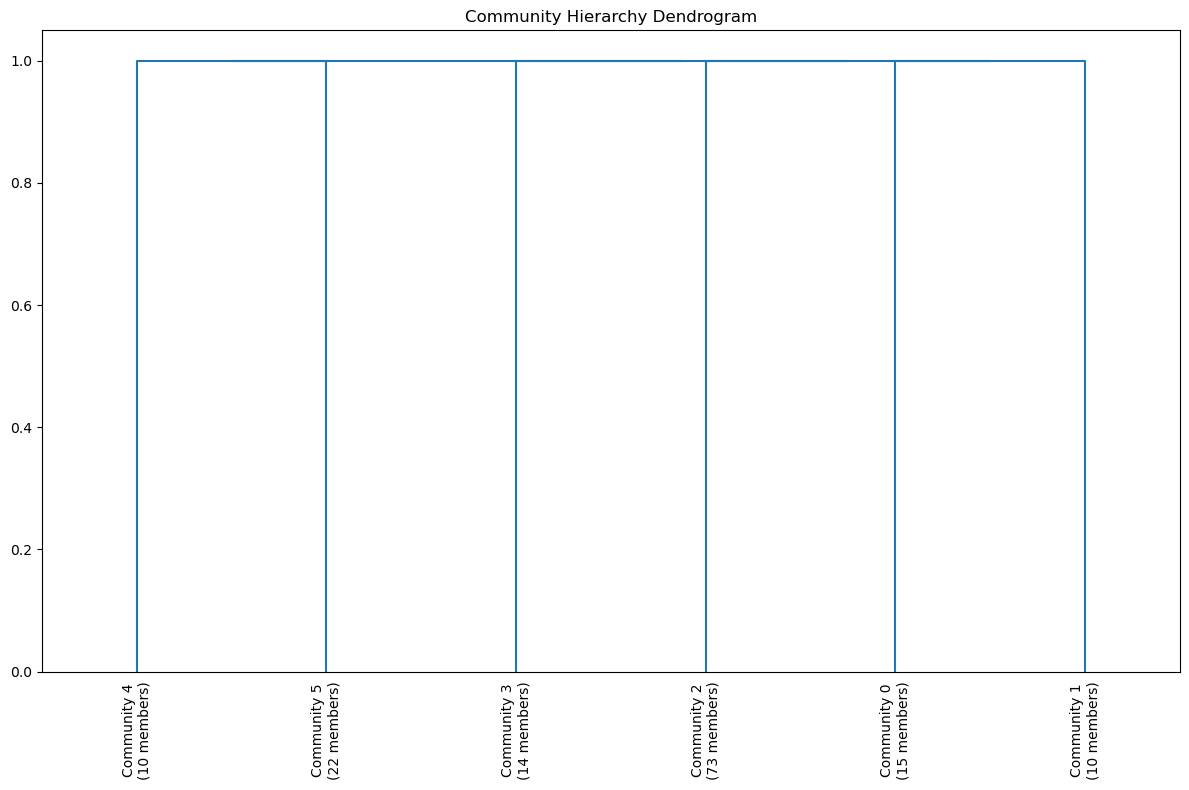

World map visualization saved as ./trade/community_world_map.png


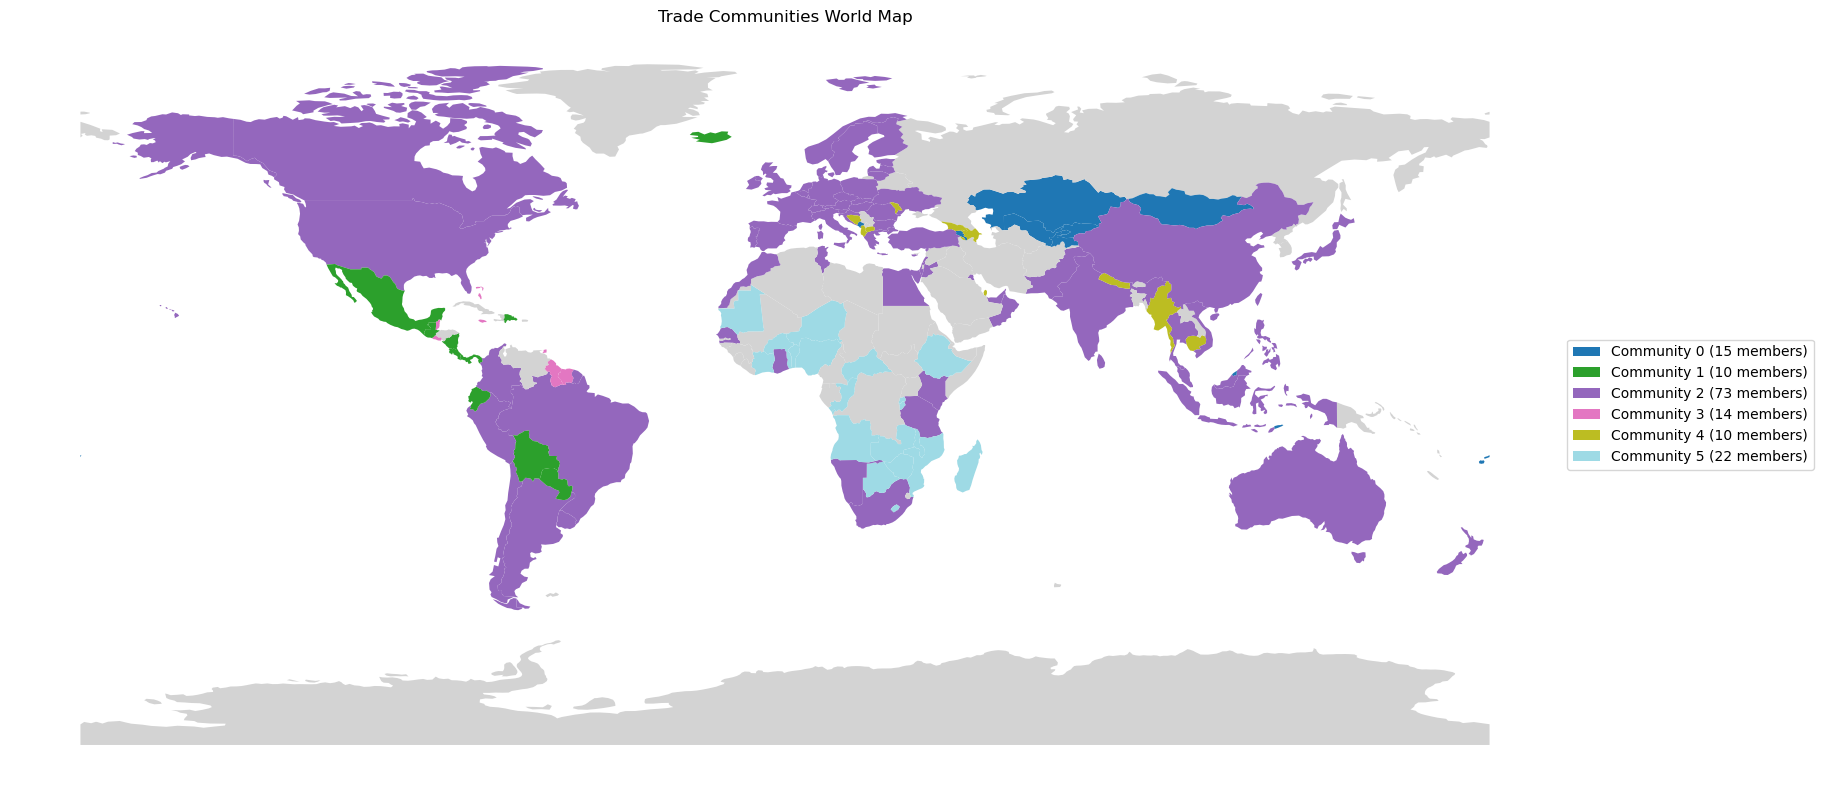

World map visualization saved as ./trade/visualizations/world_map.png


In [36]:
# Initialize detector
detector = WSBMCommunityDetector("./trade/trade_graph.graphml")

# Create output directory
output_dir = "./trade/visualizations"
os.makedirs(output_dir, exist_ok=True)

# Detect communities
communities, state = detector.detect_communities_graphtool(n_blocks=None)

# Analyze communities
stats = detector.analyze_communities(communities)

# Print statistics
print("\nCommunity Statistics:")
print(f"Total communities: {len(stats['size'])}")
print(f"Total nodes: {sum(stats['size'])}")

try:
    # Display all visualizations
    detector.visualize_communities(communities, state, show=True)
    detector.plot_dendrogram(communities, show=True)
    detector.visualize_communities_on_map(communities, show=True)

    # Save to files with proper paths
    detector.visualize_communities(
        communities, 
        state, 
        output_file=os.path.join(output_dir, 'communities.png'), 
        show=False
    )
    detector.plot_dendrogram(
        communities, 
        output_file=os.path.join(output_dir, 'dendrogram.png'), 
        show=False
    )
    detector.visualize_communities_on_map(
        communities, 
        output_file=os.path.join(output_dir, 'world_map.png'), 
        show=False
    )
    
except Exception as e:
    print(f"Error during visualization: {str(e)}")

In [37]:
def analyze_mapping_coverage(communities, world_data):
    """Analyze which countries are successfully mapped to Natural Earth data"""
    # Get country mapping
    country_mapping, territory_mapping = create_country_mapping()
    
    # Extract countries from communities
    your_countries = set()
    for node in communities.keys():
        country = node.split('.')[0] if '.' in node else node
        your_countries.add(country)
    
    # Track mapping results
    mapped_countries = set()
    unmapped_countries = set()
    territory_mapped = set()
    
    # Check each country
    for country in your_countries:
        if country in territory_mapping:
            territory_mapped.add(f"{country} -> {territory_mapping[country]}")
            continue
            
        mapped_name = country_mapping.get(country, country)
        if mapped_name in world_data['NAME'].values:
            mapped_countries.add(f"{country} -> {mapped_name}")
        else:
            unmapped_countries.add(country)
    
    # Print results
    print(f"\nMapping Coverage Analysis:")
    print("-" * 50)
    print(f"Total countries in your data: {len(your_countries)}")
    print(f"Successfully mapped: {len(mapped_countries)}")
    print(f"Mapped as territories: {len(territory_mapped)}")
    print(f"Failed to map: {len(unmapped_countries)}")
    
    print("\nSuccessfully mapped countries:")
    print("-" * 25)
    for mapping in sorted(mapped_countries):
        print(mapping)
        
    print("\nTerritory mappings:")
    print("-" * 25)
    for mapping in sorted(territory_mapped):
        print(mapping)
    
    print("\nUnmapped countries:")
    print("-" * 25)
    for country in sorted(unmapped_countries):
        print(country)
    
    return mapped_countries, territory_mapped, unmapped_countries

# Run the analysis
world = gpd.read_file(get_natural_earth_data())
mapped, territories, unmapped = analyze_mapping_coverage(communities, world)


Mapping Coverage Analysis:
--------------------------------------------------
Total countries in your data: 144
Successfully mapped: 124
Mapped as territories: 6
Failed to map: 14

Successfully mapped countries:
-------------------------
Albania -> Albania
Angola -> Angola
Argentina -> Argentina
Armenia -> Armenia
Australia -> Australia
Austria -> Austria
Azerbaijan -> Azerbaijan
Bahamas -> Bahamas
Belgium -> Belgium
Belize -> Belize
Benin -> Benin
Bolivia -> Bolivia
Bosnia and Herzegovina -> Bosnia and Herz.
Botswana -> Botswana
Brazil -> Brazil
Brunei -> Brunei
Bulgaria -> Bulgaria
Burkina Faso -> Burkina Faso
Burundi -> Burundi
Cambodia -> Cambodia
Canada -> Canada
Central African Republic -> Central African Rep.
Chile -> Chile
China -> China
Colombia -> Colombia
Congo -> Congo
Costa Rica -> Costa Rica
Cote dIvoire -> Côte d'Ivoire
Croatia -> Croatia
Cyprus -> Cyprus
Czech Republic -> Czechia
Denmark -> Denmark
Dominican Republic -> Dominican Rep.
East Timor -> Timor-Leste
Ecuador 

In [11]:
def get_standard_country_name(country):
    """Standardize country names"""
    name_mapping = {
        'USA': 'United States of America',
        'US': 'United States of America',
        'United States': 'United States of America',
        'U.S.': 'United States of America',
        'U.S.A.': 'United States of America',
        # Add more mappings as needed
    }
    return name_mapping.get(country, country)

# In visualize_communities_on_map method, modify the country mapping:
country_communities = {}
for node, comm in communities.items():
    country = node.split('.')[0] if '.' in node else node
    country = get_standard_country_name(country)
    country_communities[country] = comm

In [12]:
# Get all country names from your dataset
countries = set()
for node in communities.keys():
    country = node.split('.')[0] if '.' in node else node
    countries.add(country)

print("Countries in your dataset:")
print("-" * 25)
for country in sorted(countries):
    print(country)

# Get Natural Earth country names
world = gpd.read_file(get_natural_earth_data())
ne_countries = sorted(world['NAME'].unique())

print("\nNatural Earth country names:")
print("-" * 25)
for country in ne_countries:
    print(country)

# Find mismatches
print("\nCountries not found in Natural Earth:")
print("-" * 25)
for country in sorted(countries):
    if country not in ne_countries:
        print(country)

Countries in your dataset:
-------------------------
Albania
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Barbados
Belgium
Belize
Benin
Bermuda
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei
Bulgaria
Burkina Faso
Burundi
Cambodia
Canada
Cape Verde
Central African Republic
Chile
China
Colombia
Congo
Costa Rica
Cote dIvoire
Croatia
Cyprus
Czech Republic
Denmark
Dominican Republic
East Timor
Ecuador
Egypt
El Salvador
Estonia
Ethiopia(excludes Eritrea)
European Union
Fiji
Finland
France
French Polynesia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guyana
Hong Kong
Hungary
Iceland
India
Indonesia
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kuwait
Kyrgyz Republic
Latvia
Lebanon
Lesotho
Lithuania
Luxembourg
Macao
Madagascar
Malawi
Malaysia
Maldives
Malta
Mauritania
Mauritius
Mexico
Moldova
Mongolia
Montenegro
Montserrat
Morocco
Mozambique
Myanmar
Namibia
Nepal
Netherlands
New Zealand
Nicaragua
Niger
Nigeria
Nor

In [13]:
len(countries), len(world)

(144, 177)

In [14]:
# Load Natural Earth data and inspect its structure
world = gpd.read_file(get_natural_earth_data())

# Print all columns to understand what data we have
print("Columns in Natural Earth dataset:")
print(world.columns.tolist())

# Count different types of territories
print("\nTerritory types:")
for col in ['TYPE', 'ADMIN', 'SOVEREIGNT']:  # Common classification columns
    if col in world.columns:
        print(f"\n{col} counts:")
        print(world[col].value_counts())

# Total count
print(f"\nTotal geometries: {len(world)}")

Columns in Natural Earth dataset:
['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM0_A3_KO

In [15]:
# Print detailed breakdown
print("Detailed Territory Analysis:")
print("-" * 30)

# Check sovereign countries
sovereign = world[world['TYPE'] == 'Sovereign country']
print(f"\nSovereign countries: {len(sovereign)}")

# Check dependencies
dependencies = world[world['TYPE'] == 'Dependency']
print(f"Dependencies: {len(dependencies)}")

# Check disputed territories
disputed = world[world['TYPE'].isin(['Disputed', 'Indeterminate'])]
print(f"Disputed/Indeterminate: {len(disputed)}")

# Check ADMIN vs SOVEREIGNT differences
print("\nUnique counts:")
print(f"ADMIN names: {world['ADMIN'].nunique()}")
print(f"SOVEREIGNT names: {world['SOVEREIGNT'].nunique()}")
print(f"NAME values: {world['NAME'].nunique()}")

# Print territories with different ADMIN and SOVEREIGNT
print("\nTerritories with different ADMIN and SOVEREIGNT:")
diff_territories = world[world['ADMIN'] != world['SOVEREIGNT']]
print(diff_territories[['NAME', 'ADMIN', 'SOVEREIGNT', 'TYPE']].to_string())

Detailed Territory Analysis:
------------------------------

Sovereign countries: 156
Dependencies: 3
Disputed/Indeterminate: 6

Unique counts:
ADMIN names: 177
SOVEREIGNT names: 171
NAME values: 177

Territories with different ADMIN and SOVEREIGNT:
                       NAME                                ADMIN                SOVEREIGNT           TYPE
20             Falkland Is.                     Falkland Islands            United Kingdom       Disputed
22                Greenland                            Greenland                   Denmark        Country
23   Fr. S. Antarctic Lands  French Southern and Antarctic Lands                    France     Dependency
45              Puerto Rico                          Puerto Rico  United States of America     Dependency
79                Palestine                            Palestine                    Israel  Indeterminate
134           New Caledonia                        New Caledonia                    France     Dependency


In [16]:
def create_country_mapping():
    """Create mapping between dataset countries and Natural Earth names"""
    return {
        'Andorra': 'Andorra',  # Sovereign microstate
        'Antigua and Barbuda': 'Antigua and Barb.',  # Natural Earth abbreviation
        'Aruba': 'Aruba',  # Dutch territory
        'Bahrain': 'Bahrain',  # Check if under different name
        'Barbados': 'Barbados',  # Should be present
        'Bermuda': 'Bermuda',  # British territory
        'Bosnia and Herzegovina': 'Bosnia and Herz.',  # Natural Earth abbreviation
        'Cape Verde': 'Cabo Verde',  # Official name change
        'Central African Republic': 'Central African Rep.',  # Natural Earth abbreviation
        'Cote dIvoire': "Côte d'Ivoire",  # Special character
        'Czech Republic': 'Czechia',  # Official name change
        'Dominican Republic': 'Dominican Rep.',  # Natural Earth abbreviation
        'East Timor': 'Timor-Leste',  # Official name
        'Ethiopia(excludes Eritrea)': 'Ethiopia',  # Remove parenthetical
        'European Union': None,  # Not a country, skip
        'French Polynesia': 'French Polynesia',  # French territory
        'Grenada': 'Grenada',  # Should be present
        'Hong Kong': 'Hong Kong S.A.R.',  # Special administrative region
        'Kyrgyz Republic': 'Kyrgyzstan',  # Alternative name
        'Macao': 'Macao S.A.R',  # Special administrative region
        'Maldives': 'Maldives',  # Should be present
        'Malta': 'Malta',  # Should be present
        'Mauritius': 'Mauritius',  # Should be present
        'Montserrat': 'Montserrat',  # British territory
        'Occ.Pal.Terr': 'Palestine',  # Palestine territories
        'Other Asia': 'Taiwan',  # Common alternative name
        'Sao Tome and Principe': 'São Tomé and Principe',  # Special character
        'Seychelles': 'Seychelles',  # Should be present
        'Singapore': 'Singapore',  # Should be present
        'Slovak Republic': 'Slovakia',  # Official name
        'United States': 'United States of America'  # Full name
    }

# Verify mappings
def verify_country_mapping(mapping, world_data):
    """Verify that mapped names exist in Natural Earth data"""
    ne_names = set(world_data['NAME'].values)
    
    print("Mapping Verification:")
    print("-" * 20)
    
    for original, mapped in mapping.items():
        if mapped is None:
            print(f"Skipped: {original}")
        elif mapped in ne_names:
            print(f"✓ {original} -> {mapped}")
        else:
            print(f"✗ {original} -> {mapped} (not found in Natural Earth)")

# Test the mappings
mapping = create_country_mapping()
verify_country_mapping(mapping, world)

Mapping Verification:
--------------------
✗ Andorra -> Andorra (not found in Natural Earth)
✗ Antigua and Barbuda -> Antigua and Barb. (not found in Natural Earth)
✗ Aruba -> Aruba (not found in Natural Earth)
✗ Bahrain -> Bahrain (not found in Natural Earth)
✗ Barbados -> Barbados (not found in Natural Earth)
✗ Bermuda -> Bermuda (not found in Natural Earth)
✓ Bosnia and Herzegovina -> Bosnia and Herz.
✗ Cape Verde -> Cabo Verde (not found in Natural Earth)
✓ Central African Republic -> Central African Rep.
✓ Cote dIvoire -> Côte d'Ivoire
✓ Czech Republic -> Czechia
✓ Dominican Republic -> Dominican Rep.
✓ East Timor -> Timor-Leste
✓ Ethiopia(excludes Eritrea) -> Ethiopia
Skipped: European Union
✗ French Polynesia -> French Polynesia (not found in Natural Earth)
✗ Grenada -> Grenada (not found in Natural Earth)
✗ Hong Kong -> Hong Kong S.A.R. (not found in Natural Earth)
✓ Kyrgyz Republic -> Kyrgyzstan
✗ Macao -> Macao S.A.R (not found in Natural Earth)
✗ Maldives -> Maldives (not fo

In [19]:
def create_country_mapping():
    """Create mapping between dataset countries and Natural Earth names"""
    return {
        # Successfully verified mappings - keep these
        'Bosnia and Herzegovina': 'Bosnia and Herz.',
        'Central African Republic': 'Central African Rep.',
        'Cote dIvoire': "Côte d'Ivoire",
        'Czech Republic': 'Czechia',
        'Dominican Republic': 'Dominican Rep.',
        'East Timor': 'Timor-Leste',
        'Ethiopia(excludes Eritrea)': 'Ethiopia',
        'European Union': None,  # Skip
        'Kyrgyz Republic': 'Kyrgyzstan',
        'Occ.Pal.Terr': 'Palestine',
        'Other Asia': 'Taiwan',
        'Slovak Republic': 'Slovakia',
        'United States': 'United States of America',
        
        # Missing countries that need checking with ADMIN/SOVEREIGNT
        'Andorra': 'Andorra',  # Need to check ADMIN/SOVEREIGNT
        'Antigua and Barbuda': 'Antigua and Barbuda',  # Check ADMIN
        'Aruba': 'Netherlands',  # Part of Netherlands
        'Bahrain': 'Bahrain',  # Should be present
        'Barbados': 'Barbados',  # Check ADMIN
        'Bermuda': 'United Kingdom',  # Part of UK
        'Cape Verde': 'Cabo Verde',  # Modern name
        'French Polynesia': 'France',  # Part of France
        'Grenada': 'Grenada',  # Check ADMIN
        'Hong Kong': 'China',  # Part of China
        'Macao': 'China',  # Part of China
        'Maldives': 'Maldives',  # Check ADMIN
        'Malta': 'Malta',  # Should be present
        'Mauritius': 'Mauritius',  # Should be present
        'Montserrat': 'United Kingdom',  # Part of UK
        'Sao Tome and Principe': 'Sao Tome and Principe',  # Check spelling
        'Seychelles': 'Seychelles',  # Check ADMIN
        'Singapore': 'Singapore'  # Should be present
    }

# Let's also check the ADMIN and SOVEREIGNT columns
print("Checking alternative names in Natural Earth:")
for country in ['Andorra', 'Antigua and Barbuda', 'Bahrain', 'Barbados', 
                'Grenada', 'Maldives', 'Malta', 'Mauritius', 'Seychelles', 'Singapore']:
    matches = world[world['ADMIN'].str.contains(country, case=False, na=False) | 
                   world['SOVEREIGNT'].str.contains(country, case=False, na=False)]
    if not matches.empty:
        print(f"\n{country}:")
        print(matches[['NAME', 'ADMIN', 'SOVEREIGNT']].to_string())

Checking alternative names in Natural Earth:


In [20]:
! pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 15.2 MB/s eta 0:00:00a 0:00:01


In [21]:
import pycountry
import pandas as pd
import numpy as np

def create_country_mapping_pycountry():
    """Create mapping using pycountry library"""
    # Initialize mapping dictionary
    mapping = {}
    
    # Get your country list
    your_countries = [
        'Andorra', 'Antigua and Barbuda', 'Aruba', 'Bahrain', 'Barbados',
        'Bermuda', 'Bosnia and Herzegovina', 'Cape Verde', 'Central African Republic',
        'Cote dIvoire', 'Czech Republic', 'Dominican Republic', 'East Timor',
        'Ethiopia(excludes Eritrea)', 'European Union', 'French Polynesia',
        'Grenada', 'Hong Kong', 'Kyrgyz Republic', 'Macao', 'Maldives', 'Malta',
        'Mauritius', 'Montserrat', 'Occ.Pal.Terr', 'Other Asia', 
        'Sao Tome and Principe', 'Seychelles', 'Singapore', 'Slovak Republic',
        'United States'
    ]
    
    # Special cases mapping
    special_cases = {
        'Cote dIvoire': 'Côte d\'Ivoire',
        'East Timor': 'Timor-Leste',
        'Ethiopia(excludes Eritrea)': 'Ethiopia',
        'European Union': None,
        'Kyrgyz Republic': 'Kyrgyzstan',
        'Occ.Pal.Terr': 'Palestine, State of',
        'Other Asia': 'Taiwan',
        'Slovak Republic': 'Slovakia',
        'Czech Republic': 'Czechia',
        'Cape Verde': 'Cabo Verde'
    }
    
    for country in your_countries:
        if country in special_cases:
            mapping[country] = special_cases[country]
        else:
            try:
                # Try exact match
                c = pycountry.countries.get(name=country)
                if c:
                    mapping[country] = c.name
                    continue
                
                # Try fuzzy search
                matches = pycountry.countries.search_fuzzy(country)
                if matches:
                    mapping[country] = matches[0].name
            except LookupError:
                # Keep original name if no match found
                mapping[country] = country
    
    return mapping

def verify_pycountry_mapping(mapping):
    """Verify country mapping using pycountry"""
    print("Mapping Verification (pycountry):")
    print("-" * 30)
    
    for original, mapped in mapping.items():
        if mapped is None:
            print(f"Skipped: {original}")
        elif pycountry.countries.get(name=mapped):
            print(f"✓ {original} -> {mapped}")
        else:
            # Try to find similar names
            try:
                matches = pycountry.countries.search_fuzzy(mapped)
                suggestions = [m.name for m in matches[:3]]
                print(f"✗ {original} -> {mapped} (Suggestions: {', '.join(suggestions)})")
            except LookupError:
                print(f"✗ {original} -> {mapped} (No matches found)")

# Test the new mapping
mapping = create_country_mapping_pycountry()
verify_pycountry_mapping(mapping)

Mapping Verification (pycountry):
------------------------------
✓ Andorra -> Andorra
✓ Antigua and Barbuda -> Antigua and Barbuda
✓ Aruba -> Aruba
✓ Bahrain -> Bahrain
✓ Barbados -> Barbados
✓ Bermuda -> Bermuda
✓ Bosnia and Herzegovina -> Bosnia and Herzegovina
✓ Cape Verde -> Cabo Verde
✓ Central African Republic -> Central African Republic
✓ Cote dIvoire -> Côte d'Ivoire
✓ Czech Republic -> Czechia
✓ Dominican Republic -> Dominican Republic
✓ East Timor -> Timor-Leste
✓ Ethiopia(excludes Eritrea) -> Ethiopia
Skipped: European Union
✓ French Polynesia -> French Polynesia
✓ Grenada -> Grenada
✓ Hong Kong -> Hong Kong
✓ Kyrgyz Republic -> Kyrgyzstan
✓ Macao -> Macao
✓ Maldives -> Maldives
✓ Malta -> Malta
✓ Mauritius -> Mauritius
✓ Montserrat -> Montserrat
✓ Occ.Pal.Terr -> Palestine, State of
✗ Other Asia -> Taiwan (Suggestions: Taiwan, Province of China, China)
✓ Sao Tome and Principe -> Sao Tome and Principe
✓ Seychelles -> Seychelles
✓ Singapore -> Singapore
✓ Slovak Republic -> S